# SWB Regression Pipeline - HFA RPE vs Profit Encoding 
Created: 07/30/24 \
Updated: 09/30/2024 \
*ran with 1 sec regression dfs from 09/25/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



09302024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load beta power data 

In [6]:
epoch_len = '1sec'

In [7]:
band = 'hfa' 
hfa_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [10]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [11]:
# ####### NEW DATA FRAME 
hfa_reg_df = hfa_df.copy()
hfa_reg_df = hfa_reg_df[hfa_reg_df.roi.isin(keep_rois)]

# RPE ONLY MODELS

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'rpe'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+rpe'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3751.33it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3785.75it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3880.86it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3748.51it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3726.80it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3726.12it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3706.53it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3730.16it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3721.19it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3751.73it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'rpe']

In [14]:
results = single_elec_permutation_results(results_dict,hfa_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.032479   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.032003   
2     MS002_lacas3-lacas4   MS002    acc   14                    -0.007230   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.012090   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.031570   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                    -0.029099   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.008994   
1185  DA039_rpins3-rpins4   DA039   pins   22                     0.021879   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.029943   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.034780   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.037208                   0.029818   
1                                  -0.048571                  -0.004604   
2                                  -0.001582                  -0.016932   
3                                  -0.016087                  -0.017043   
4                                  -0.026495                  -0.013730   
...                                      ...                        ...   
1183                                0.000337                   0.022977   
1184                               -0.017599                   0.041880   
1185                               -0.031423                   0.039110   
1186                                0.027842                  -0.007299   
1187                                0.026928                  -0.002356   

      Original_Estimate_rpe  Permuted_Mean_Intercept  \
0                  0.052056                 0.006122   
1                  0.032198                -0.001428   
2                 -0.003907                -0.008737   
3                 -0.014412                 0.001128   
4                  0.039781                 0.013982   
...                     ...                      ...   
1183              -0.028883                -0.027754   
1184              -0.016686                 0.003811   
1185              -0.024698                 0.011356   
1186               0.024864                -0.019430   
1187               0.004119                -0.024055   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                               0.000936  ...              0.019948   
1                              -0.000405  ...              0.020237   
2                               0.000503  ...              0.017171   
3                              -0.000374  ...              0.020062   
4                              -0.001204  ...              0.019429   
...                                  ...  ...                   ...   
1183                            0.000714  ...              0.025866   
1184                            0.001547  ...              0.030885   
1185                            0.000366  ...              0.037807   
1186                           -0.000119  ...              0.017330   
1187                           -0.000383  ...              0.017508   

      Permuted_Std_rpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0             0.018819           1.757523                     -1.766585   
1             0.018709           2.196477                     -2.198701   
2             0.016324           0.123459                     -0.118683   
3             0.019205           0.709040                     -0.706022   
4             0.018923           1.146098                     -1.144762   
...                ...                ...                           ...   
1183          0.020949          -0.125128                     -0.014988   
1184          0.025339           0.398457      

### Save results as pickle file

In [15]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_rpemodel_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# RPE Results

In [16]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0      MS002_lacas1-lacas2   MS002    acc   14                     0.032479   
4      MS002_lacas5-lacas6   MS002    acc   14                     0.031570   
5      MS002_lacas6-lacas7   MS002  dmpfc   14                     0.019098   
8     MS002_lacas9-lacas10   MS002  dmpfc   14                    -0.022298   
9      MS002_lagit1-lagit2   MS002    amy   14                    -0.001560   
...                    ...     ...    ...  ...                          ...   
1174       DA039_rof3-rof4   DA039    ofc   22                     0.021026   
1175       DA039_rof4-rof5   DA039    ofc   22                     0.016219   
1176       DA039_rof5-rof6   DA039    ofc   22                    -0.002364   
1177       DA039_rof6-rof7   DA039  dlpfc   22                    -0.033647   
1181     DA039_rof10-rof11   DA039  dlpfc   22                    -0.064906   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.037208                   0.029818   
4                                  -0.026495                  -0.013730   
5                                  -0.017299                   0.021901   
8                                  -0.018717                  -0.053958   
9                                  -0.002429                   0.036104   
...                                      ...                        ...   
1174                               -0.042040                   0.032383   
1175                               -0.032521                   0.042898   
1176                               -0.012452                   0.049310   
1177                               -0.011088                   0.006047   
1181                                0.058482                   0.009357   

      Original_Estimate_rpe  Permuted_Mean_Intercept  \
0                  0.052056                 0.006122   
4                  0.039781                 0.013982   
5                  0.045287                 0.007682   
8                 -0.052734                -0.035099   
9                  0.033493                -0.003230   
...                     ...                      ...   
1174               0.070369                 0.005845   
1175               0.069254                 0.005084   
1176               0.048253                -0.005447   
1177               0.044836                -0.038114   
1181               0.041262                -0.040801   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                               0.000936  ...              0.019948   
4                              -0.001204  ...              0.019429   
5                              -0.000728  ...              0.020693   
8                              -0.000539  ...              0.026953   
9                               0.000163  ...              0.016395   
...                                  ...  ...                   ...   
1174                           -0.001225  ...              0.024886   
1175                           -0.000349  ...              0.022568   
1176                            0.000555  ...              0.019971   
1177                            0.000030  ...              0.016878   
1181                           -0.001677  ...              0.023617   

      Permuted_Std_rpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0             0.018819           1.757523                     -1.766585   
4             0.018923           1.146098                     -1.144762   
5             0.019995           0.788114                     -0.794670   
8             0.026581           0.605931                     -0.597873   
9             0.015878           0.128794                     -0.138832   
...                ...                ...                           ...   
1174          0.022035           1.381708                     -1.583161   
1175          0.018981           1.1

In [17]:
sig_data.roi.value_counts()



roi
ofc      52
acc      33
dmpfc    31
ains     22
dlpfc    19
amy      16
vlpfc    12
pins     11
hpc       8
Name: count, dtype: int64

In [18]:
sig_data.roi.unique()



array(['acc', 'dmpfc', 'amy', 'ains', 'ofc', 'vlpfc', 'pins', 'dlpfc',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [19]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.032479   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.032003   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.007230   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.012090   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.031570   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.037208                   0.029818   
1                               -0.048571                  -0.004604   
2                               -0.001582                  -0.016932   
3                               -0.016087                  -0.017043   
4                               -0.026495                  -0.013730   

   Original_Estimate_rpe  Permuted_Mean_Intercept  \
0               0.052056                 0.006122   
1               0.032198                -0.001428   
2              -0.003907                -0.008737   
3              -0.014412                 0.001128   
4               0.039781                 0.013982   

   Permuted_Mean_GambleChoice[T.safe]  ...  Z_Score_Intercept  \
0                            0.000936  ...           1.757523   
1                           -0.000405  ...           2.196477   
2                            0.000503  ...           0.123459   
3                           -0.000374  ...           0.709040   
4                           -0.001204  ...           1.146098   

   Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_rpe  \
0                     -1.766585         1.495091     2.727081   
1                     -2.198701        -0.226572     1.750385   
2                     -0.118683        -1.020726    -0.265777   
3                     -0.706022        -0.828603    -0.753687   
4                     -1.144762        -0.699073     2.132536   

   P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0           0.078829                      0.077298         0.134891   
1           0.028058                      0.027899         0.820756   
2           0.901744                      0.905527         0.307384   
3           0.478299                      0.480174         0.407329   
4           0.251755                      0.252308         0.484506   

   P_Value_rpe  rpe_sig  bdi_split  
0     0.006390        1          0  
1     0.080052        0          0  
2     0.790411        0          0  
3     0.451037        0          0  
4     0.032963        1          0  

[5 rows x 26 columns]

In [20]:
rpe_var = 'Z_Score_rpe'

In [21]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [22]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc    0.366218
vlpfc   -0.038368
dmpfc    0.036586
ofc      0.949825
ains     0.536856
pins     0.063558
acc      0.806002
amy      0.374212
hpc      0.204494
Name: Z_Score_rpe, dtype: float64

In [23]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [24]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     33  0.170984              6    8.541493  4.037725e-15   
1  dmpfc      225     31  0.137778              7    0.407701  6.838828e-01   
2    amy      113     16  0.141593              2    3.318014  1.223338e-03   
3   ains       71     22  0.309859              5    2.540692  1.328331e-02   
4  vlpfc       82     12  0.146341              1   -0.245853  8.064178e-01   
5    hpc      135      8  0.059259              2    2.279710  2.420477e-02   
6    ofc      202     52  0.257426             24    8.838775  4.892862e-16   
7   pins       60     11  0.183333              1    0.359412  7.205701e-01   
8  dlpfc      107     19  0.177570              9    2.543092  1.243124e-02   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.127851            1.0    0.170984      0.0000  
1      0.101514            1.0    0.137778      0.0000  
2      0.090875            1.0    0.141593      0.0002  
3      0.219988            1.0    0.309859      0.0000  
4      0.086667            1.0    0.146341      0.0008  
5      0.029825            1.0    0.059259      0.3631  
6      0.207276            1.0    0.257426      0.0000  
7      0.106354            1.0    0.183333      0.0002  
8      0.119515            1.0    0.177570      0.0000

In [25]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     33  0.170984              6    8.541493  4.037725e-15   
1  dmpfc      225     31  0.137778              7    0.407701  6.838828e-01   
2    amy      113     16  0.141593              2    3.318014  1.223338e-03   
3   ains       71     22  0.309859              5    2.540692  1.328331e-02   
4  vlpfc       82     12  0.146341              1   -0.245853  8.064178e-01   
6    ofc      202     52  0.257426             24    8.838775  4.892862e-16   
7   pins       60     11  0.183333              1    0.359412  7.205701e-01   
8  dlpfc      107     19  0.177570              9    2.543092  1.243124e-02   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.127851            1.0    0.170984      0.0000  
1      0.101514            1.0    0.137778      0.0000  
2      0.090875            1.0    0.141593      0.0002  
3      0.219988            1.0    0.309859      0.0000  
4      0.086667            1.0    0.146341      0.0008  
6      0.207276            1.0    0.257426      0.0000  
7      0.106354            1.0    0.183333      0.0002  
8      0.119515            1.0    0.177570      0.0000

# Plot Results

In [26]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_rpeonly_rpe-coeff_barplot_{epoch_len}.pdf'


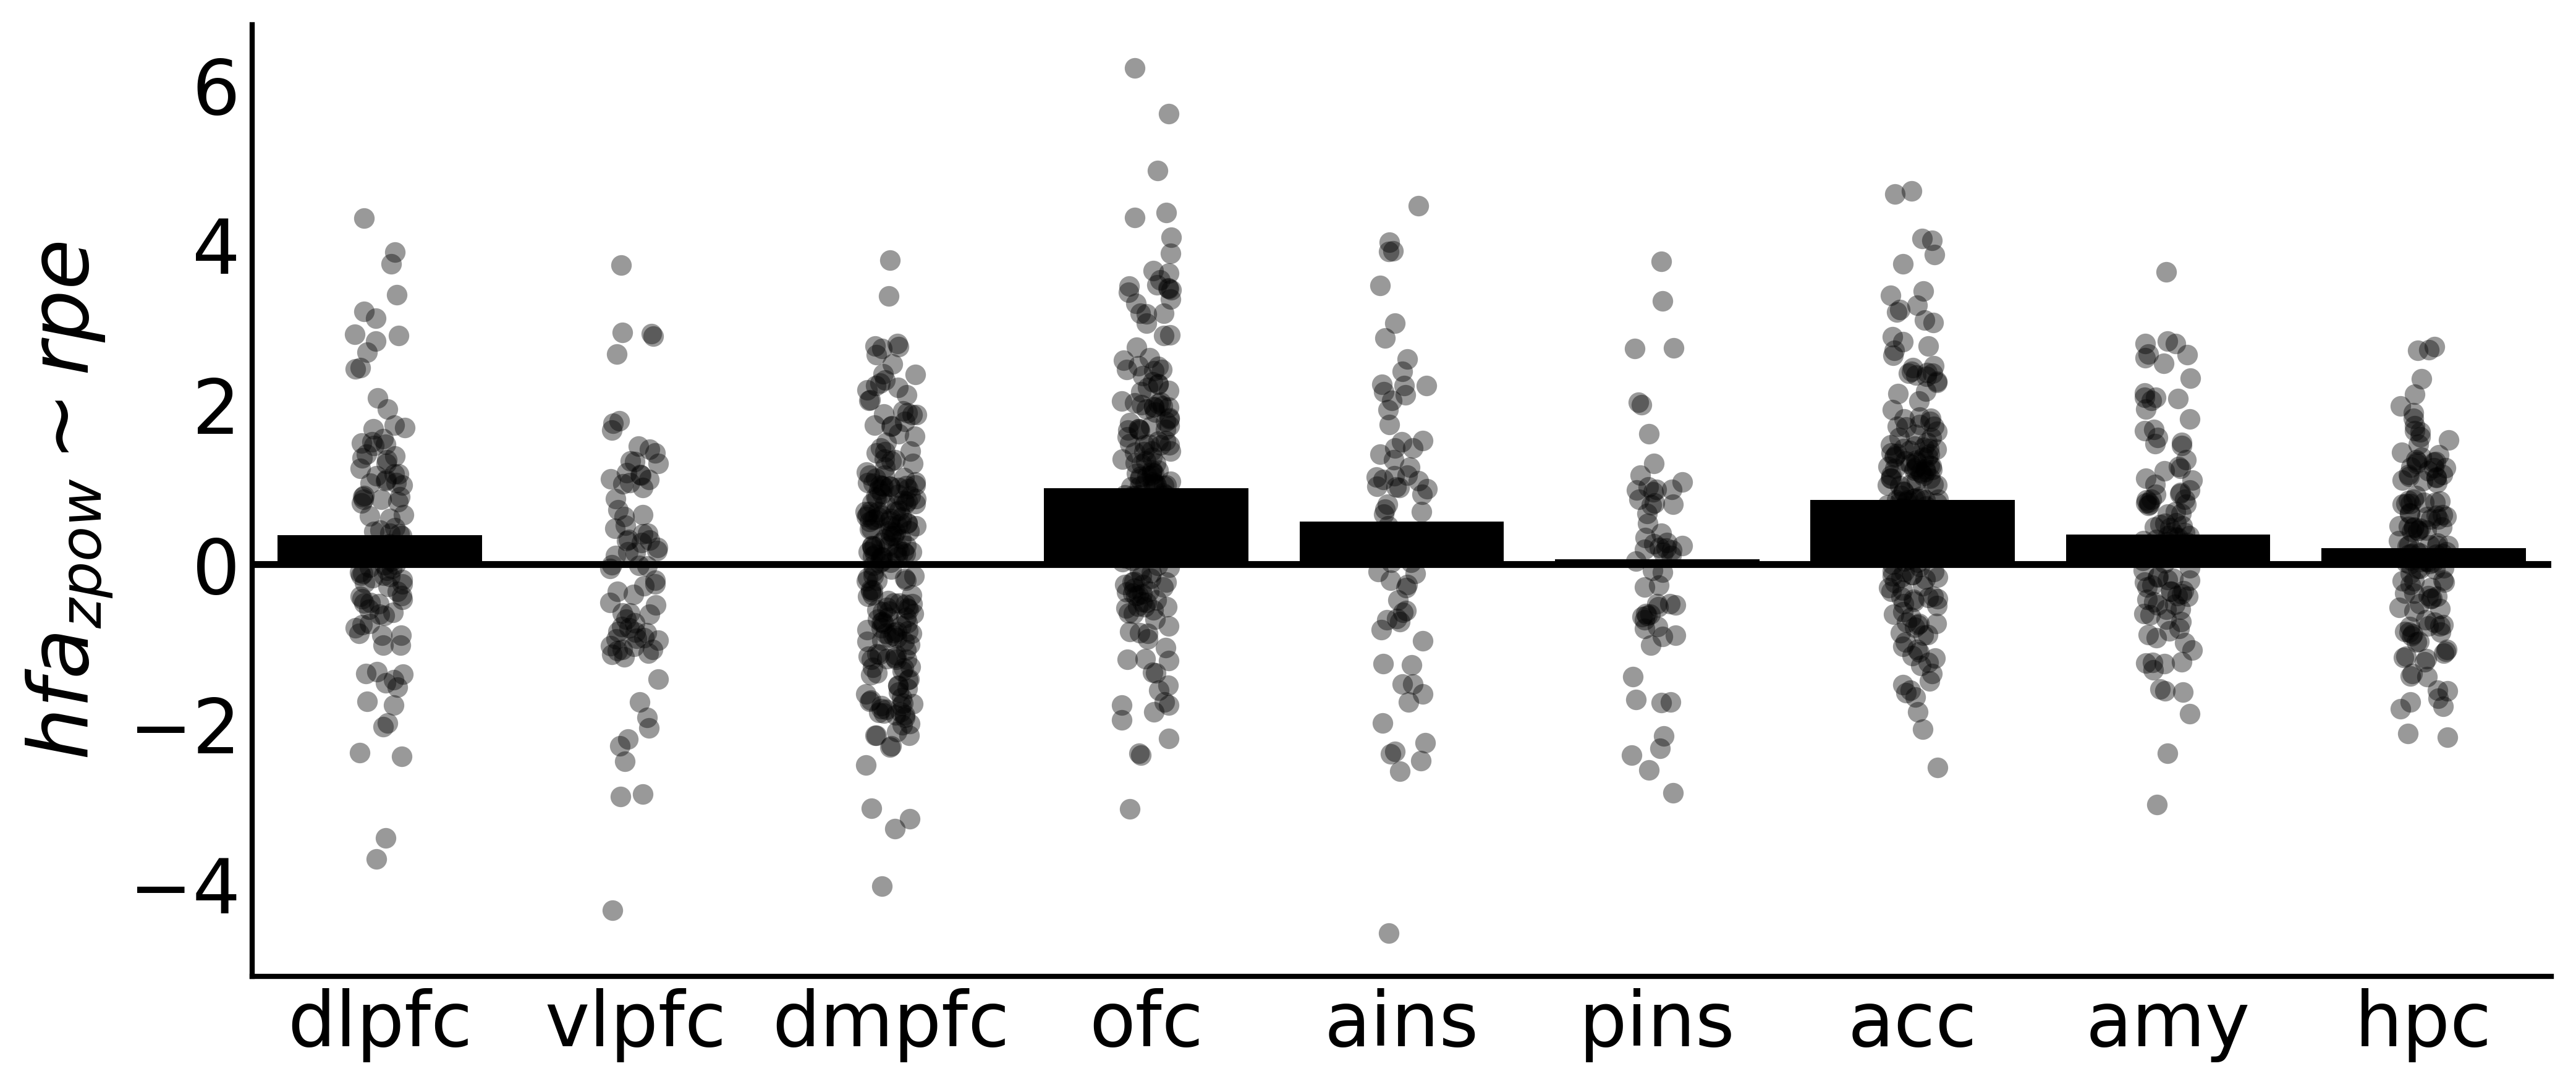

In [27]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim rpe$'


plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

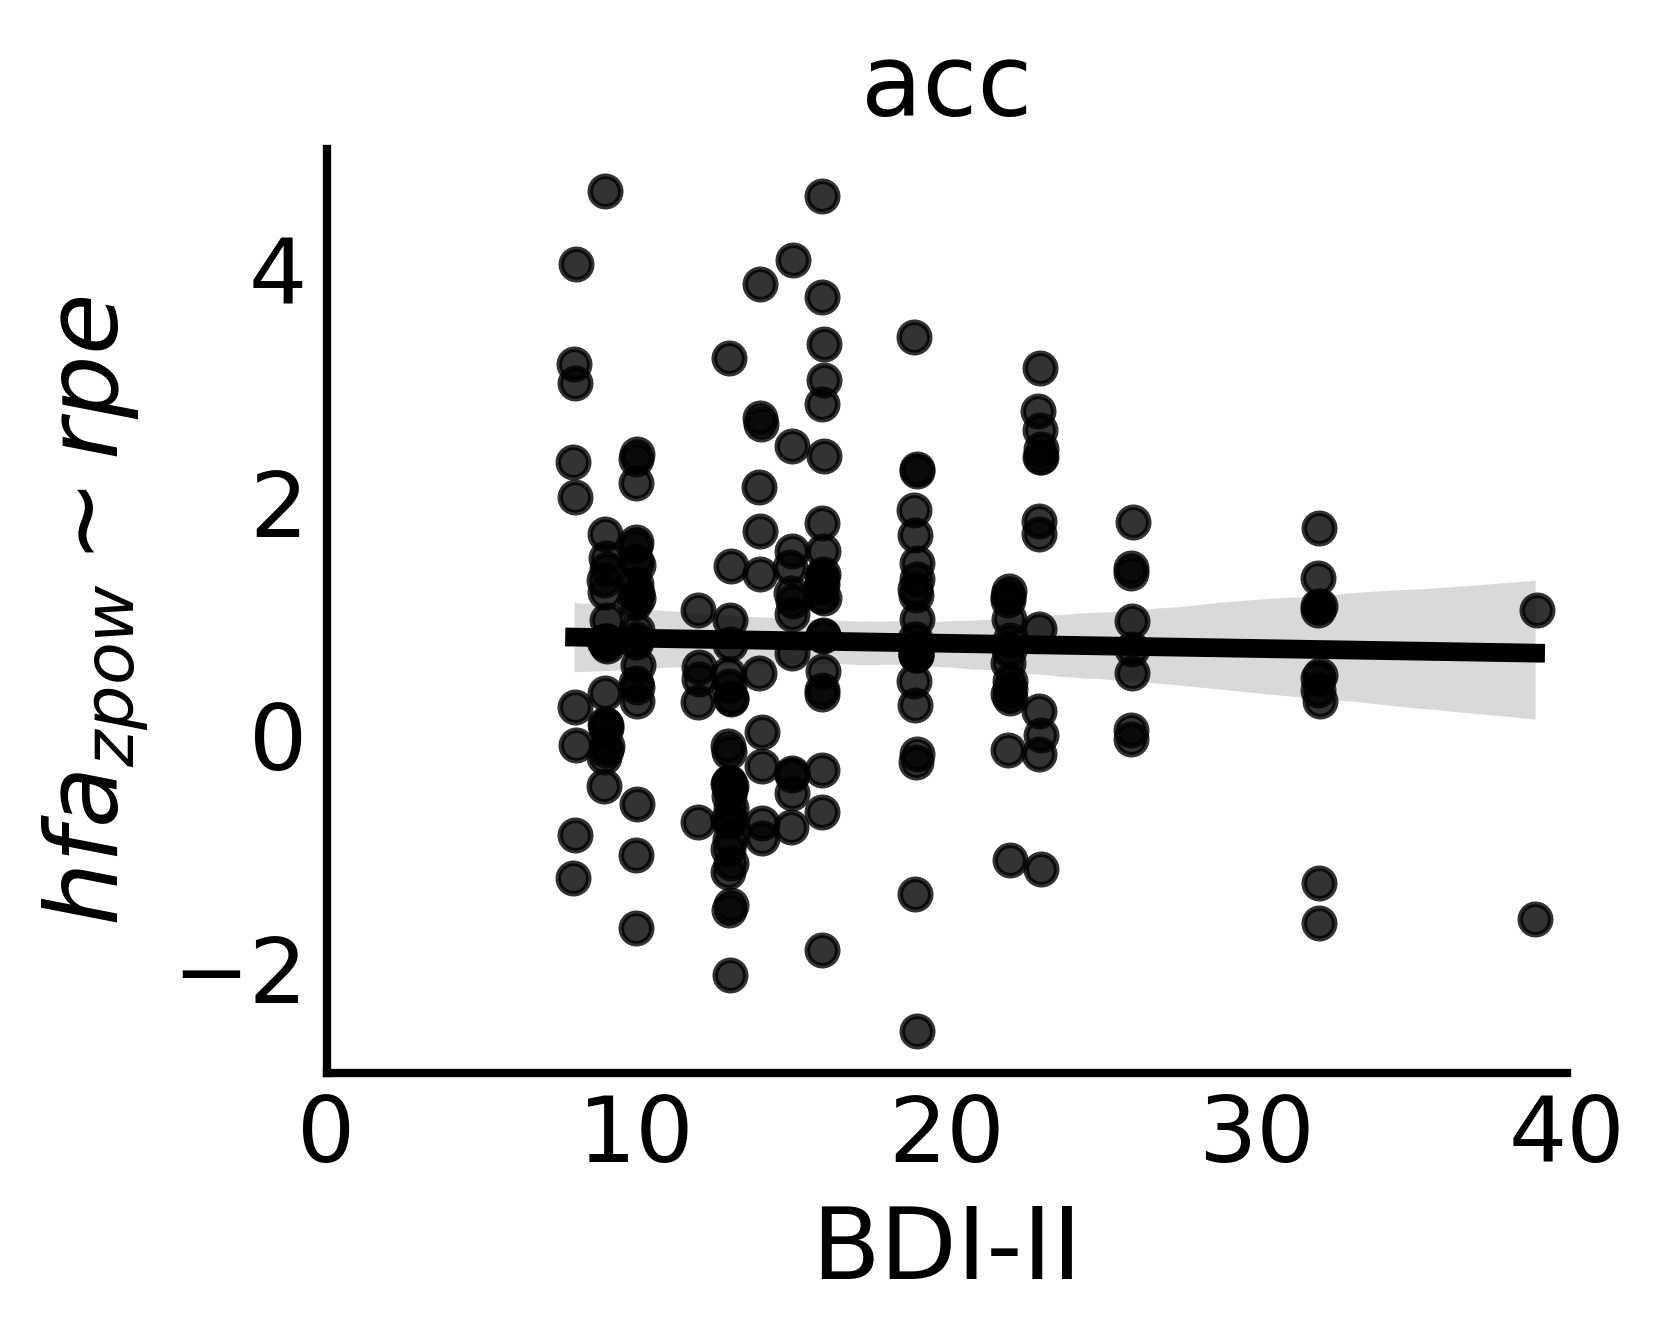

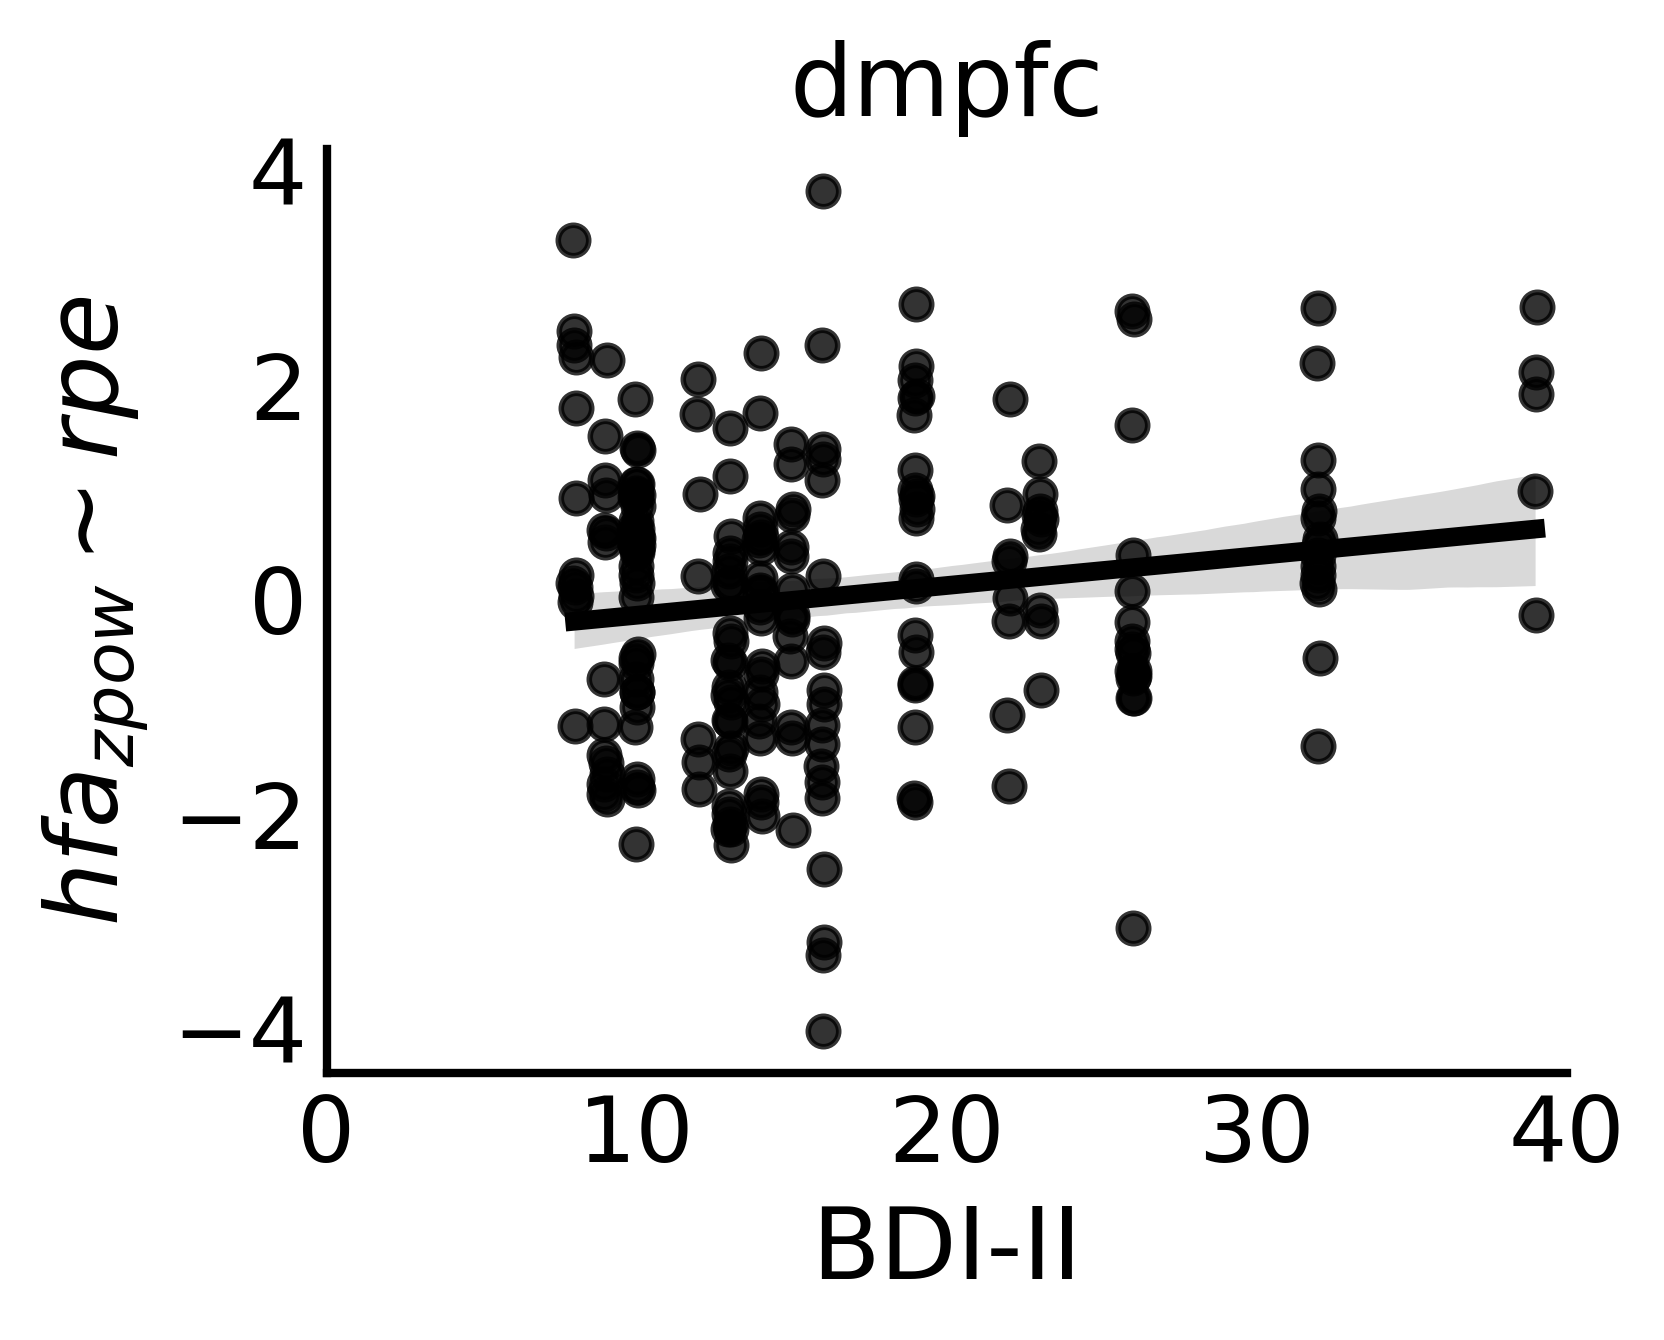

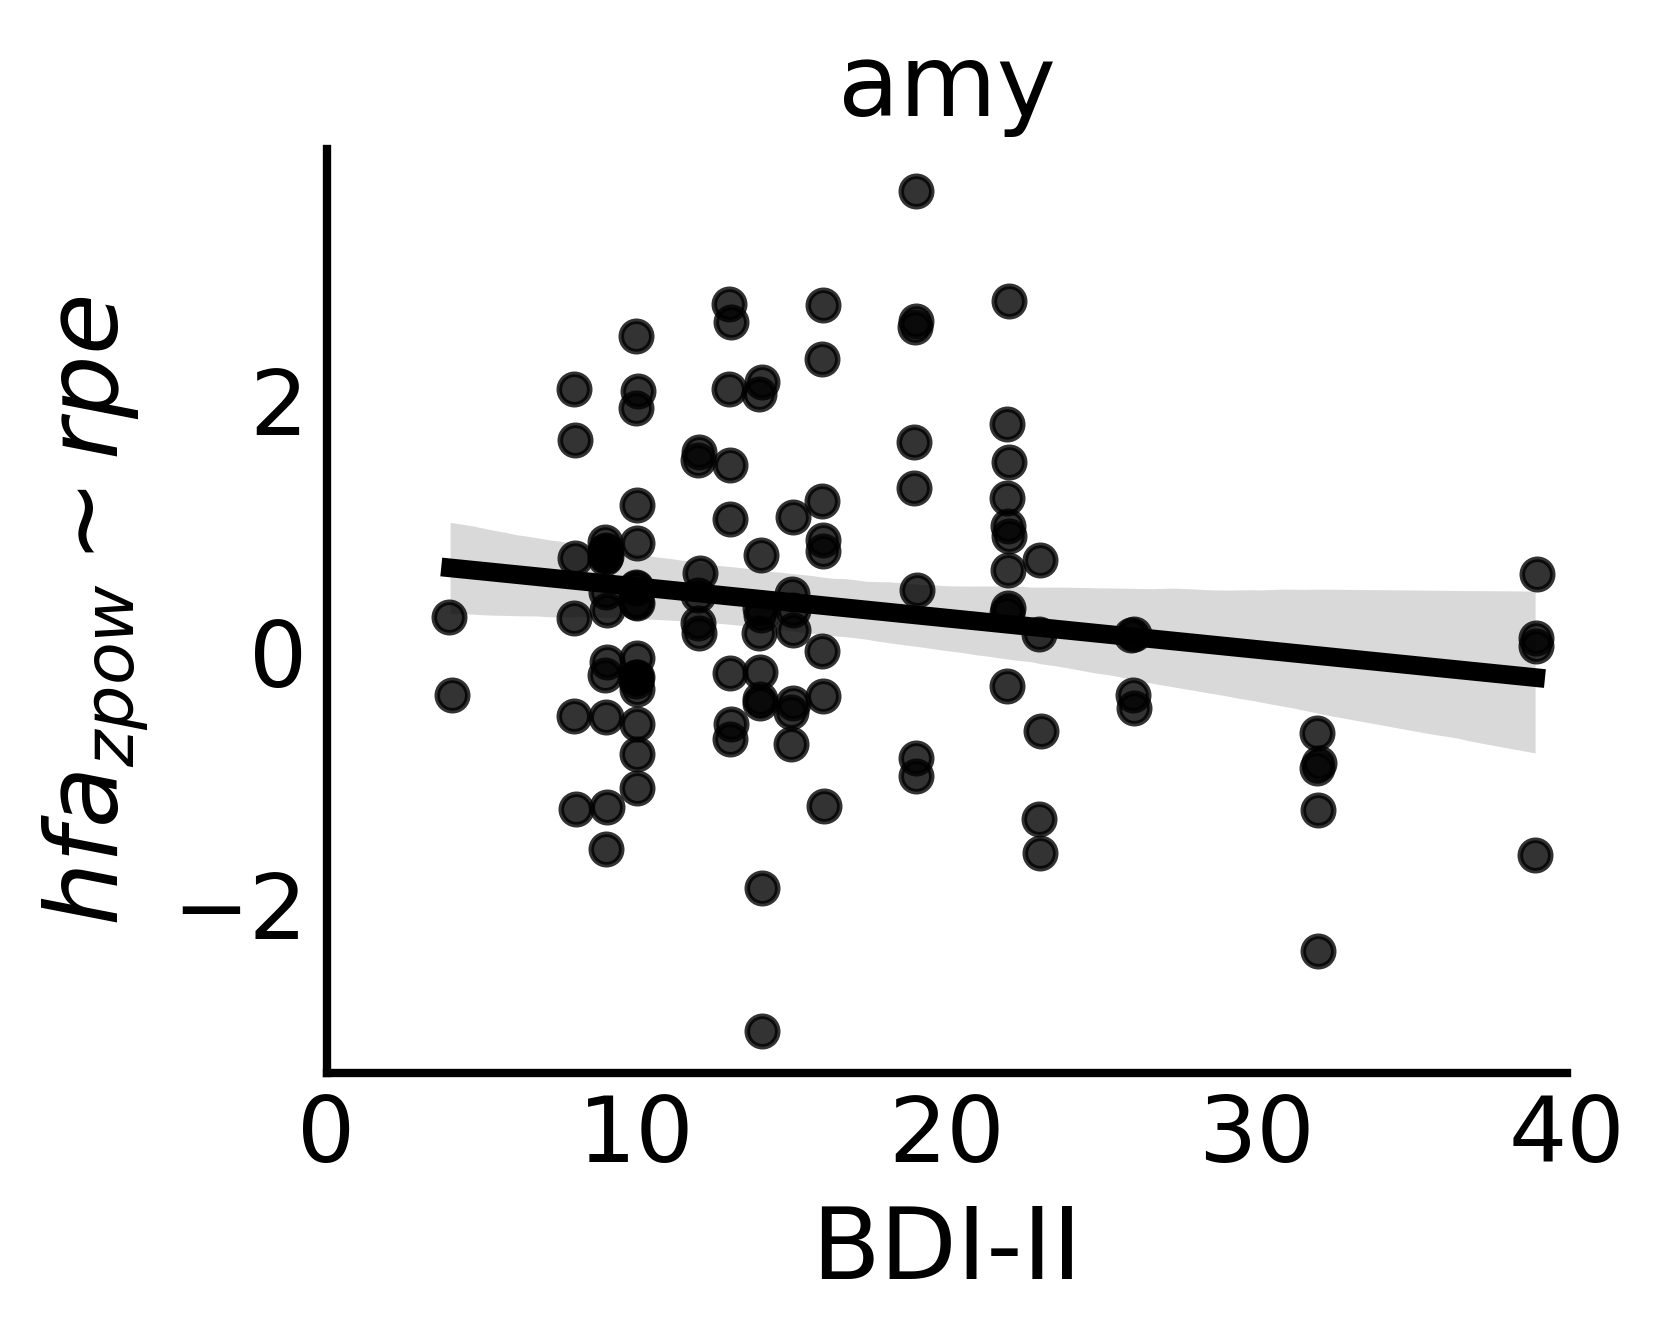

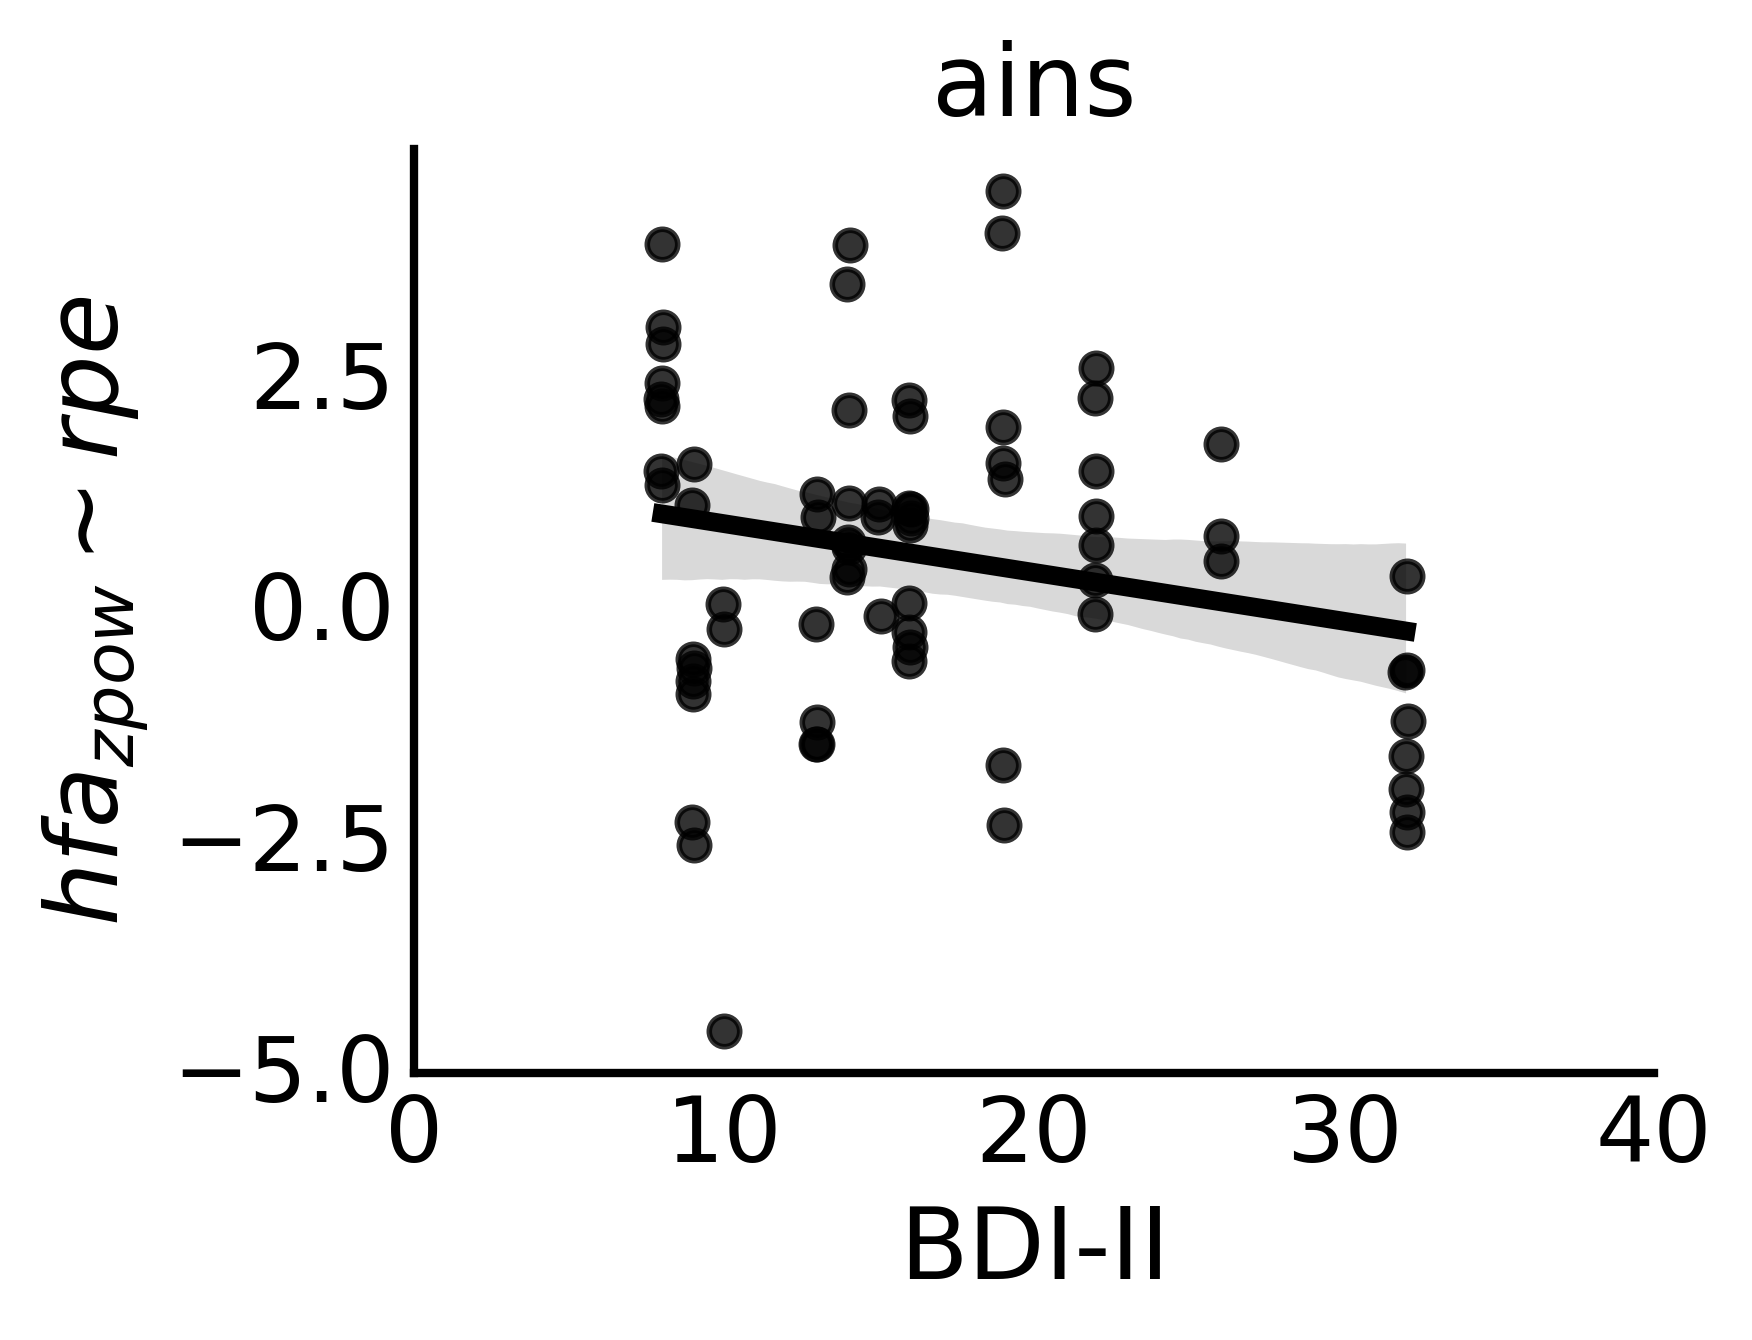

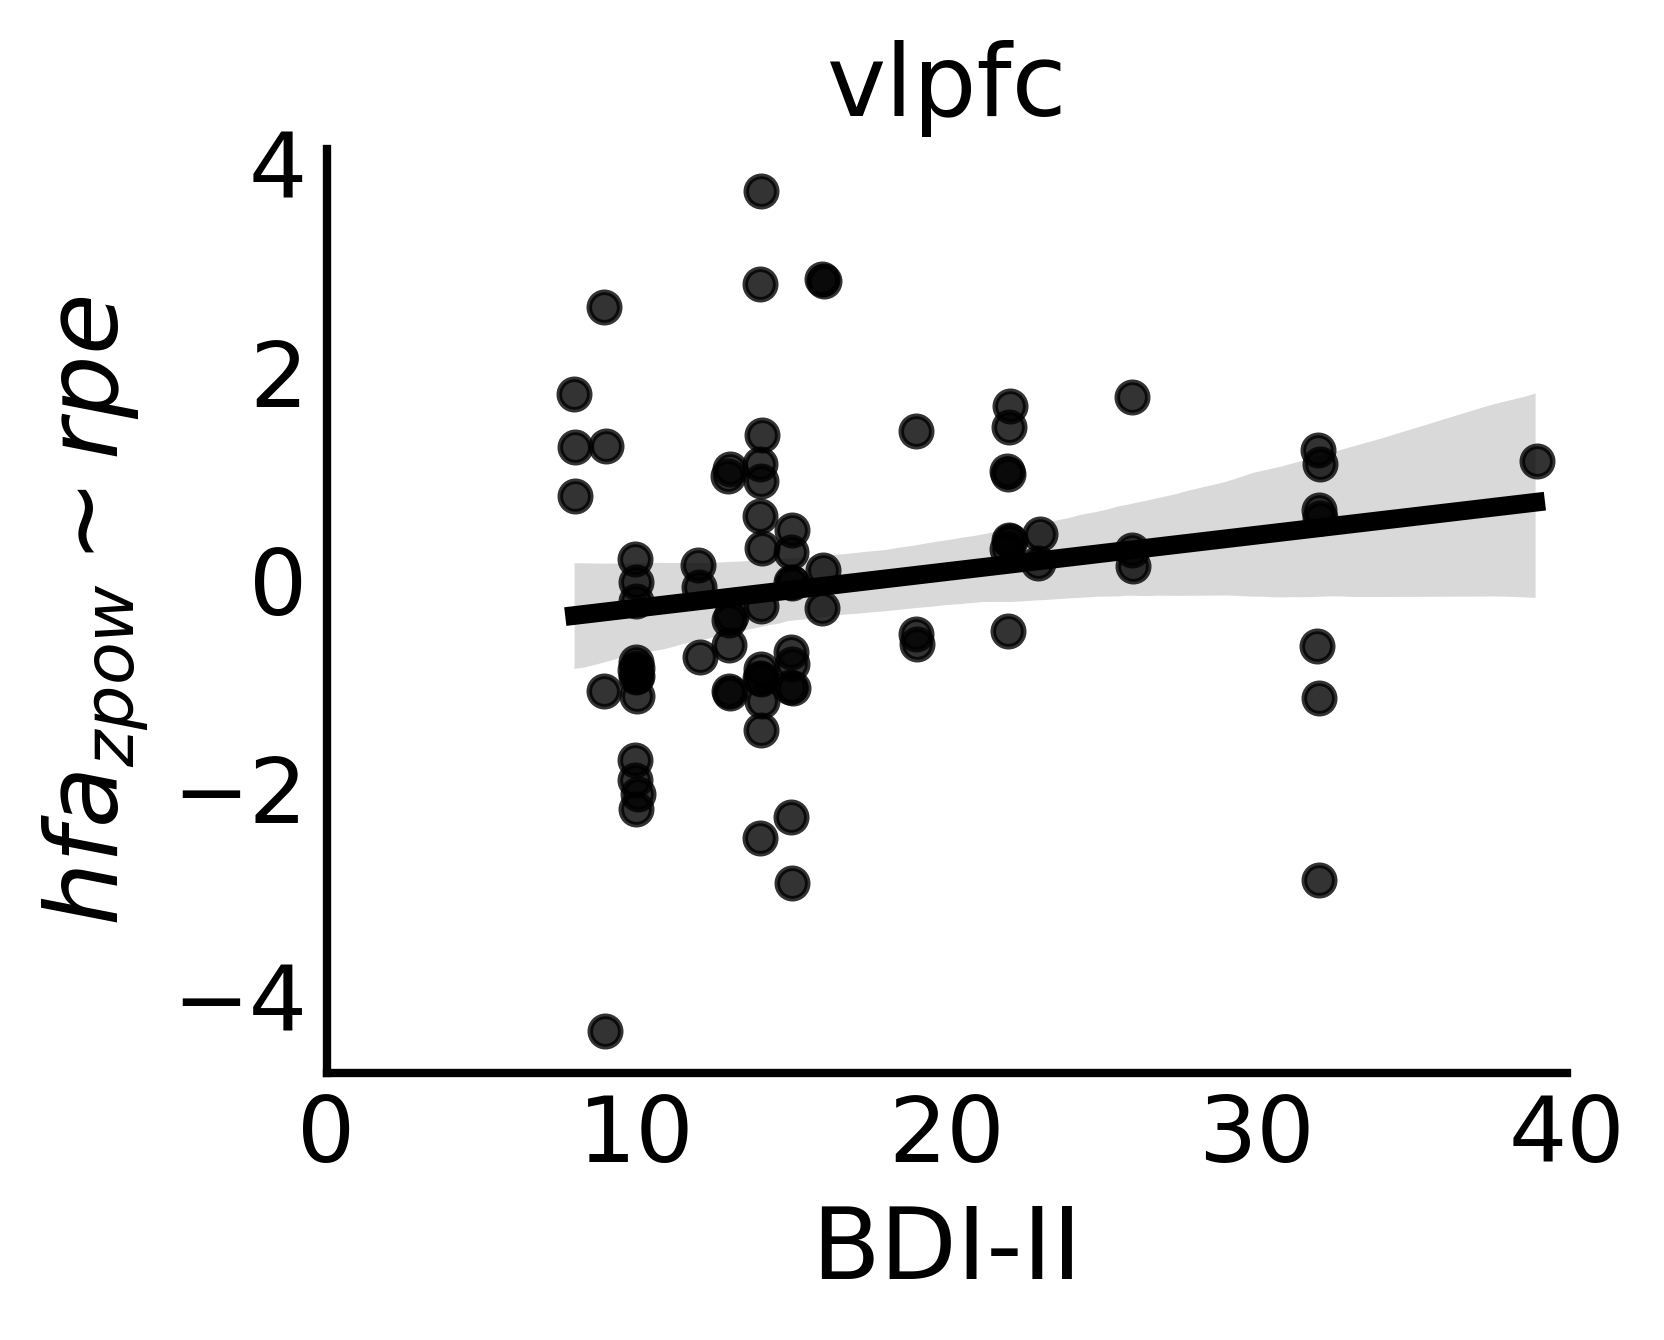

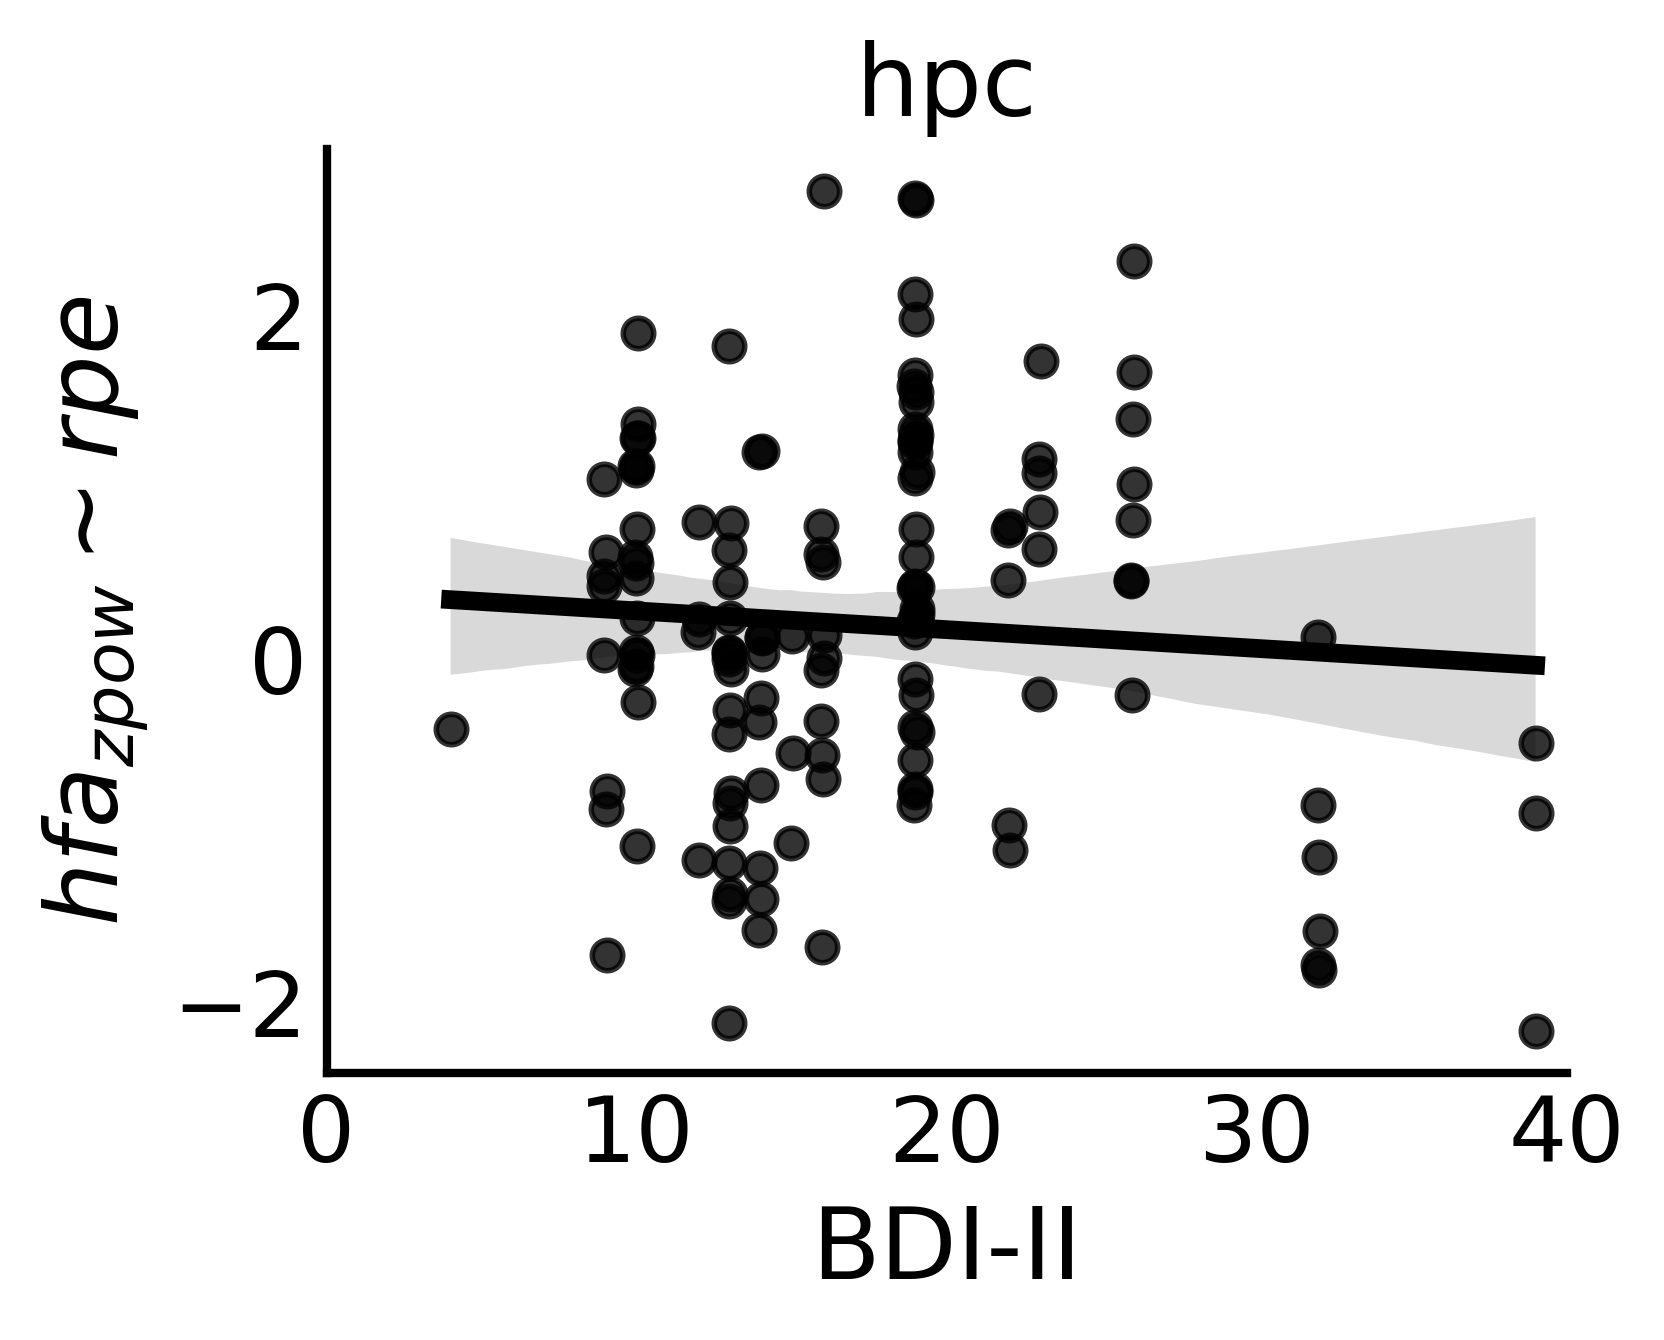

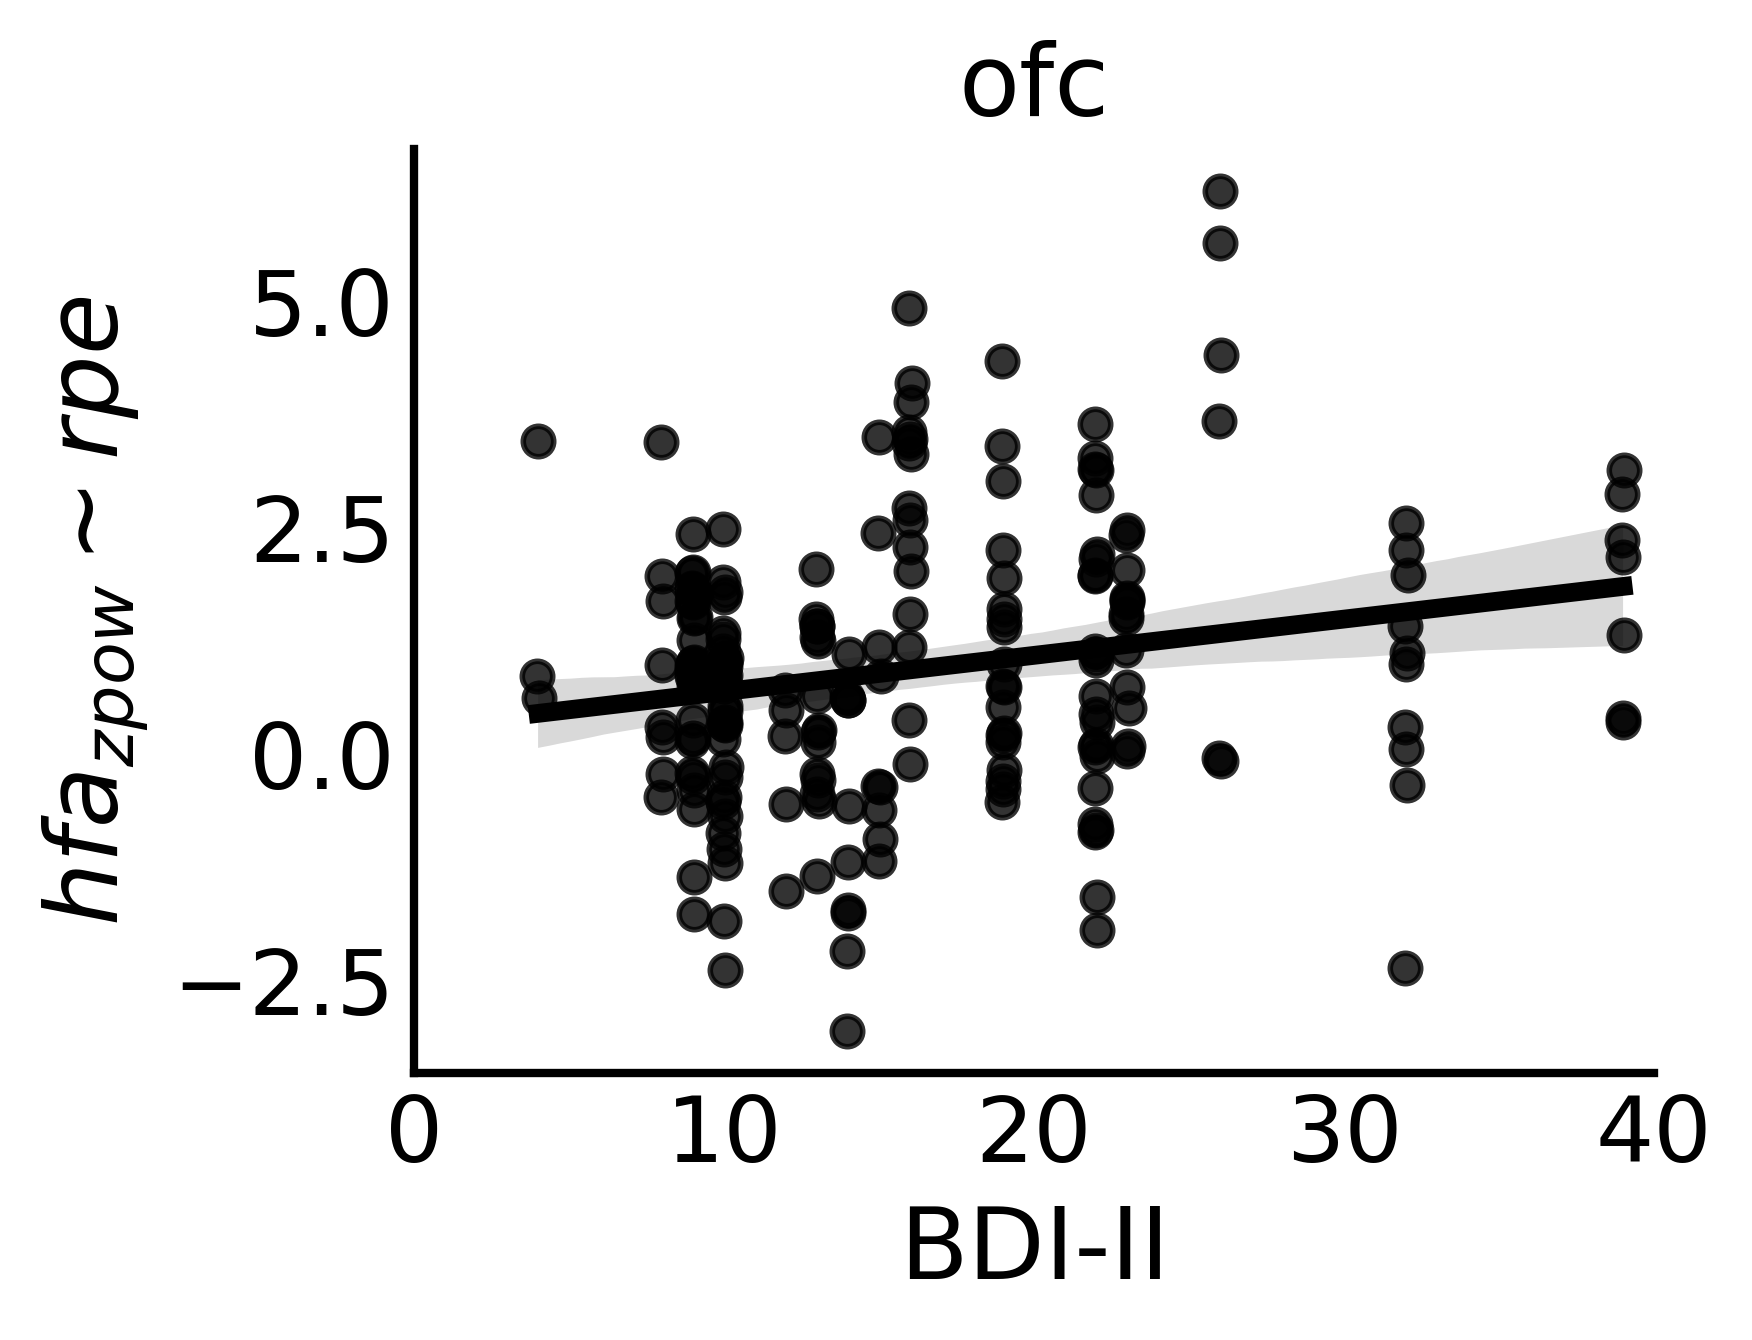

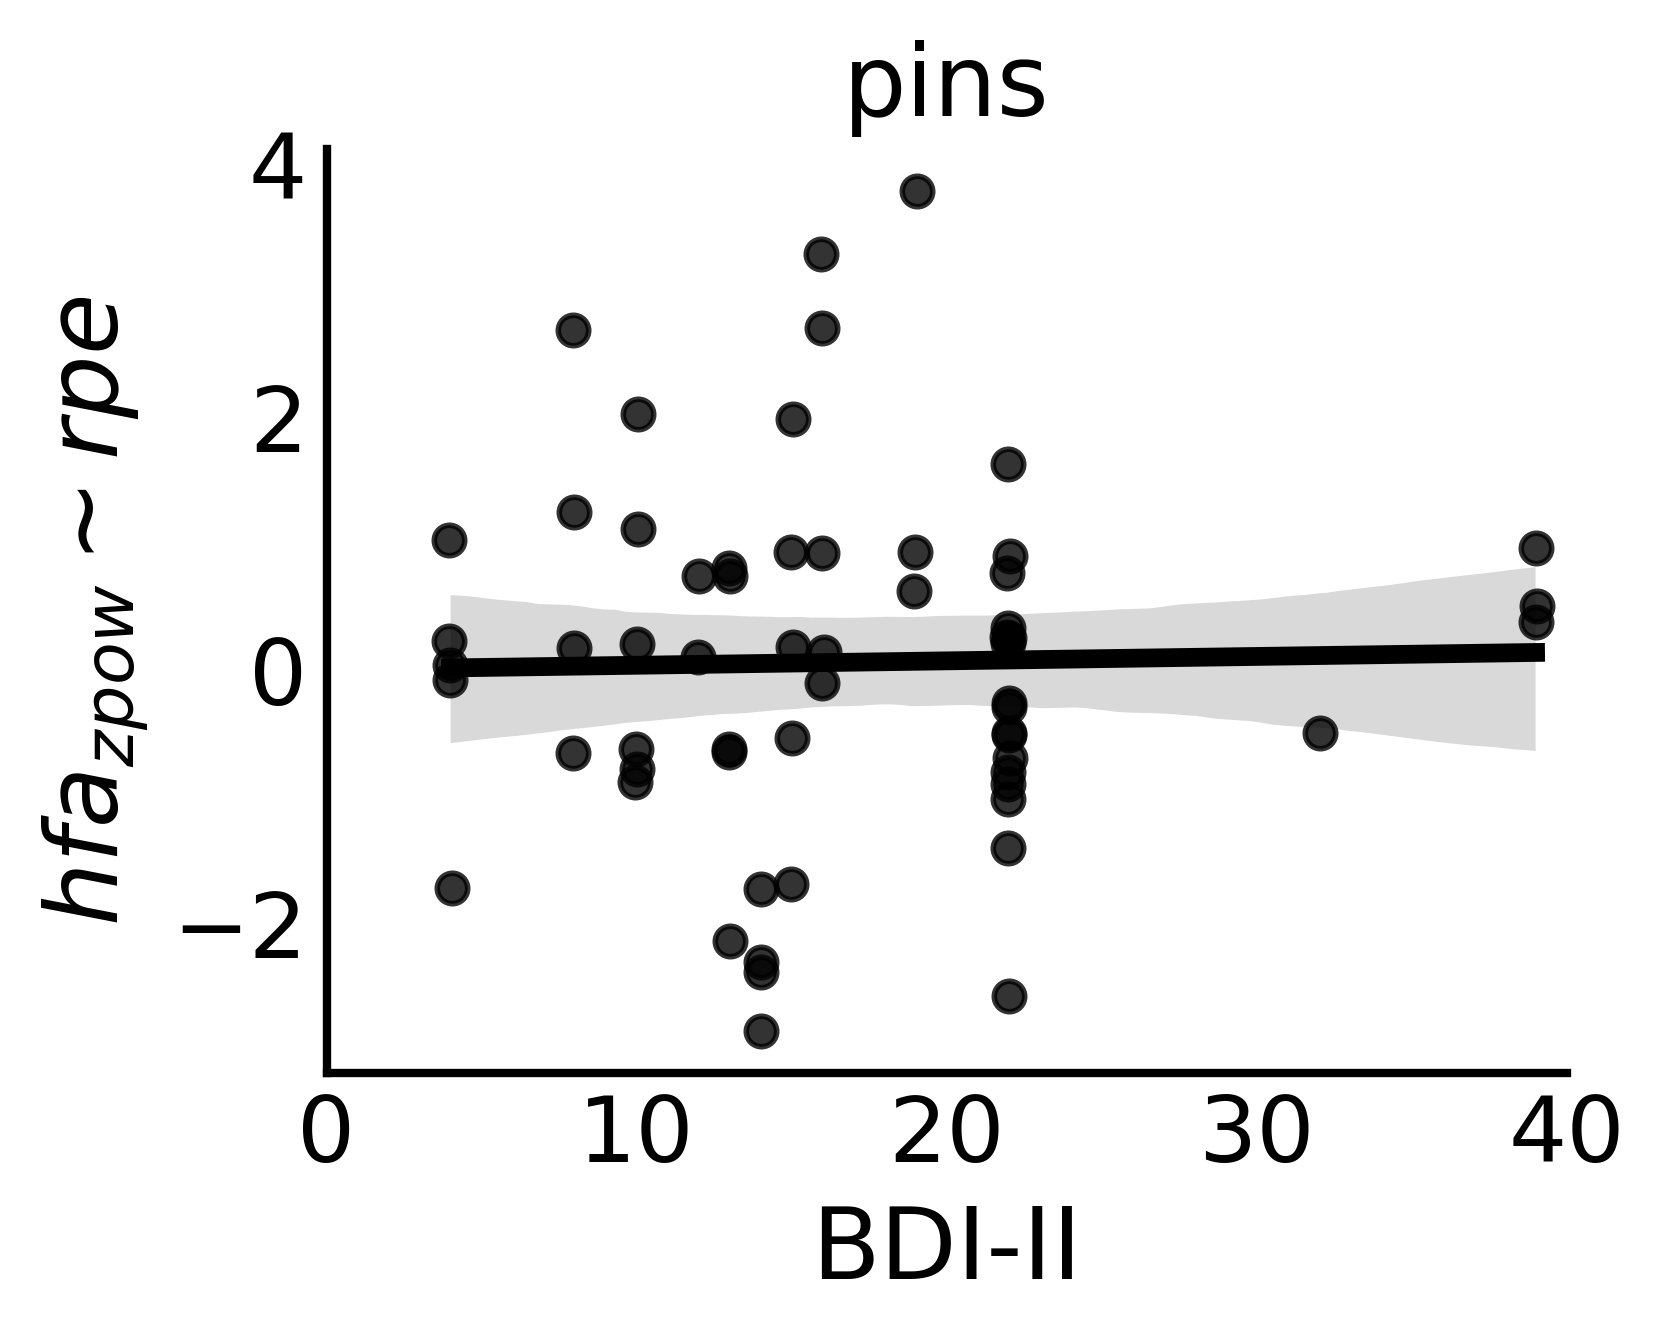

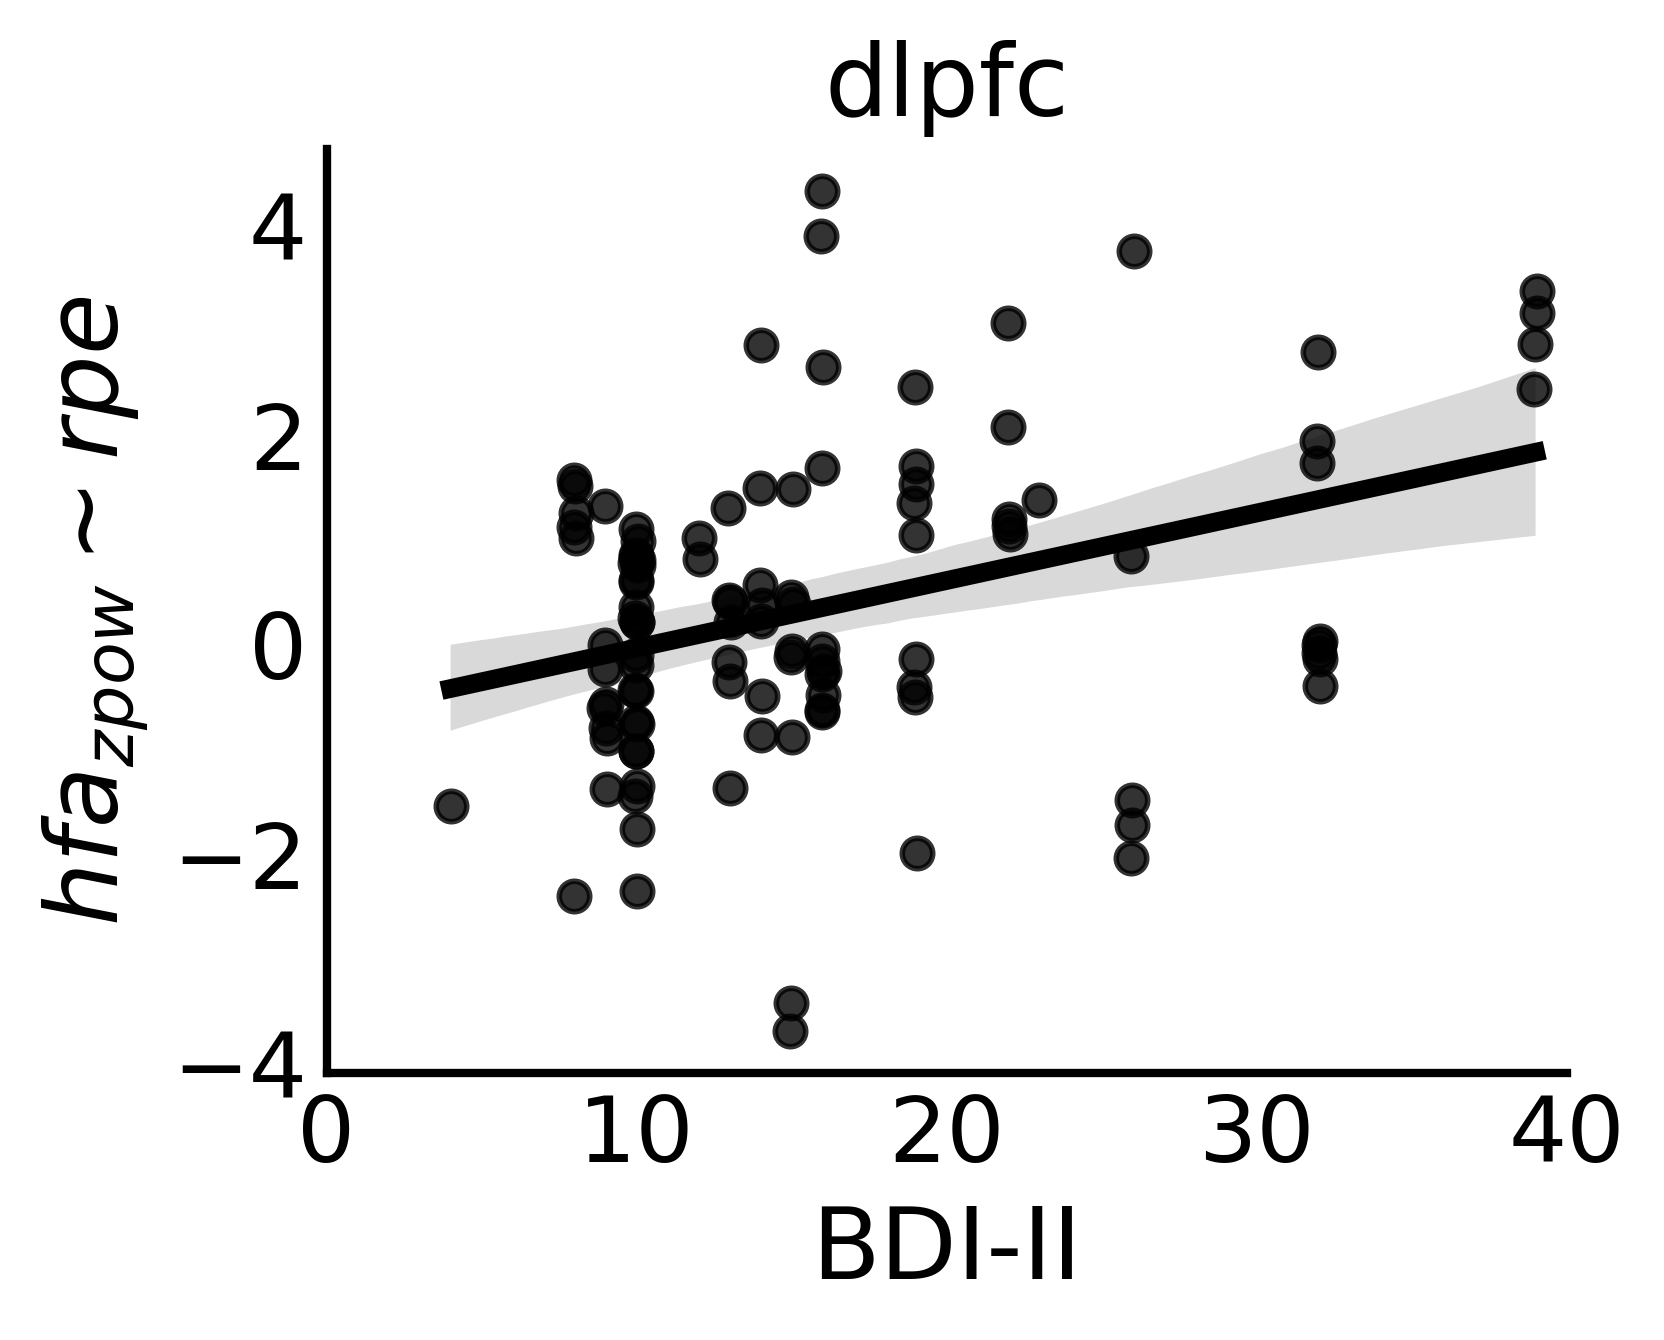

In [28]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_rpemodel_rpe-coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim rpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [29]:
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        20:52:23                                         
No. Iterations:                    16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9632      0.533     29.946     

# PROFIT ONLY MODELS

In [30]:
elec_col    = 'unique_reref_ch'
main_var    = 'Profit'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+Profit'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3773.62it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3815.36it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3804.19it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3760.03it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3733.64it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3734.85it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3718.26it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3725.84it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3756.17it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3786.68it/s]


In [31]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'Profit']

In [32]:
results = single_elec_permutation_results(results_dict,hfa_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.031415   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.031618   
2     MS002_lacas3-lacas4   MS002    acc   14                    -0.006839   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.012601   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.031315   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                    -0.030056   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.008455   
1185  DA039_rpins3-rpins4   DA039   pins   22                     0.021384   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.029429   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.034513   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.035647                  -0.026135   
1                                  -0.047999                  -0.034107   
2                                  -0.002148                  -0.006913   
3                                  -0.016831                   0.002489   
4                                  -0.026106                  -0.046063   
...                                      ...                        ...   
1183                                0.001567                   0.050177   
1184                               -0.016909                   0.057380   
1185                               -0.030847                   0.057580   
1186                                0.027241                  -0.026108   
1187                                0.026560                  -0.008173   

      Original_Estimate_Profit  Permuted_Mean_Intercept  \
0                     0.078721                 0.006155   
1                     0.041043                -0.001660   
2                    -0.014626                -0.008734   
3                    -0.027848                 0.000377   
4                     0.044541                 0.013650   
...                        ...                      ...   
1183                 -0.043542                -0.026853   
1184                 -0.024834                 0.004400   
1185                 -0.030051                 0.011600   
1186                  0.030575                -0.019587   
1187                  0.009116                -0.024215   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                               0.000884  ...              0.025927   
1                              -0.000068  ...              0.025949   
2                               0.000503  ...              0.022471   
3                               0.000706  ...              0.025632   
4                              -0.000723  ...              0.025917   
...                                  ...  ...                   ...   
1183                           -0.001586  ...              0.030928   
1184                           -0.000271  ...              0.036549   
1185                           -0.000062  ...              0.043804   
1186                            0.000255  ...              0.022502   
1187                            0.000007  ...              0.021640   

      Permuted_Std_Profit  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0                0.025897           1.728068                     -1.735805   
1                0.025355           2.291752                     -2.292718   
2                0.022485           0.147679                     -0.143491   
3                0.025395           0.787696                     -0.785106   
4                0.025538           1.172467                     -1.170444   
...                   ...                ...                           ...   
1183             0.026949          -0.300616                     

### Save results as pickle file

In [33]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_Profitmodel_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

In [34]:
sig_data = results[results.P_Value_Profit < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0      MS002_lacas1-lacas2   MS002    acc   14                     0.031415   
5      MS002_lacas6-lacas7   MS002  dmpfc   14                     0.018404   
7      MS002_lacas8-lacas9   MS002  dmpfc   14                    -0.035069   
8     MS002_lacas9-lacas10   MS002  dmpfc   14                    -0.021529   
12     MS002_laims1-laims2   MS002   ains   14                     0.033920   
...                    ...     ...    ...  ...                          ...   
1174       DA039_rof3-rof4   DA039    ofc   22                     0.023200   
1175       DA039_rof4-rof5   DA039    ofc   22                     0.018100   
1176       DA039_rof5-rof6   DA039    ofc   22                    -0.001185   
1177       DA039_rof6-rof7   DA039  dlpfc   22                    -0.032554   
1181     DA039_rof10-rof11   DA039  dlpfc   22                    -0.063984   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.035647                  -0.026135   
5                                  -0.016274                  -0.022443   
7                                   0.040560                   0.023307   
8                                  -0.019853                  -0.003062   
12                                 -0.025946                  -0.051784   
...                                      ...                        ...   
1174                               -0.044806                  -0.031549   
1175                               -0.034861                  -0.016167   
1176                               -0.013888                   0.010109   
1177                               -0.012420                  -0.030352   
1181                                0.057381                  -0.022887   

      Original_Estimate_Profit  Permuted_Mean_Intercept  \
0                     0.078721                 0.006155   
5                     0.061995                 0.008395   
7                    -0.056666                -0.007243   
8                    -0.071079                -0.035332   
12                    0.073550                 0.016139   
...                        ...                      ...   
1174                  0.102579                 0.005333   
1175                  0.095175                 0.004480   
1176                  0.063384                -0.005386   
1177                  0.058857                -0.037702   
1181                  0.052285                -0.041251   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                               0.000884  ...              0.025927   
5                              -0.001753  ...              0.026323   
7                               0.000387  ...              0.027959   
8                              -0.000221  ...              0.036622   
12                             -0.000326  ...              0.025268   
...                                  ...  ...                   ...   
1174                            0.000072  ...              0.031925   
1175                            0.000983  ...              0.028213   
1176                            0.000502  ...              0.024696   
1177                           -0.000890  ...              0.021332   
1181                           -0.000454  ...              0.028222   

      Permuted_Std_Profit  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0                0.025897           1.728068                     -1.735805   
5                0.025140           0.648421                     -0.653432   
7                0.027225          -1.694919                      1.700038   
8                0.035800           0.659383                     -0.651522   
12               0.023983           1.215000                     -1.216257   
...                   ...                ...                           ...   
1174             0.028306           1.567349          

In [35]:
sig_data.roi.value_counts()



roi
ofc      47
dmpfc    32
acc      31
ains     21
dlpfc    21
amy      16
vlpfc    14
pins      9
hpc       6
Name: count, dtype: int64

In [37]:
sig_data.roi.unique()



array(['acc', 'dmpfc', 'ains', 'ofc', 'vlpfc', 'pins', 'dlpfc', 'amy',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [38]:
# add mask col for sig cpe elecs 
results['Profit_sig']   = results['P_Value_Profit'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.031415   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.031618   
2  MS002_lacas3-lacas4   MS002  acc   14                    -0.006839   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.012601   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.031315   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.035647                  -0.026135   
1                               -0.047999                  -0.034107   
2                               -0.002148                  -0.006913   
3                               -0.016831                   0.002489   
4                               -0.026106                  -0.046063   

   Original_Estimate_Profit  Permuted_Mean_Intercept  \
0                  0.078721                 0.006155   
1                  0.041043                -0.001660   
2                 -0.014626                -0.008734   
3                 -0.027848                 0.000377   
4                  0.044541                 0.013650   

   Permuted_Mean_GambleChoice[T.safe]  ...  Z_Score_Intercept  \
0                            0.000884  ...           1.728068   
1                           -0.000068  ...           2.291752   
2                            0.000503  ...           0.147679   
3                            0.000706  ...           0.787696   
4                           -0.000723  ...           1.172467   

   Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_Profit  \
0                     -1.735805        -1.048234        3.046921   
1                     -2.292718        -1.276905        1.599865   
2                     -0.143491        -0.282426       -0.671003   
3                     -0.785106         0.080760       -1.060728   
4                     -1.170444        -1.755995        1.740332   

   P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0           0.083976                      0.082598         0.294531   
1           0.021920                      0.021864         0.201636   
2           0.882596                      0.885903         0.777617   
3           0.430875                      0.432391         0.935633   
4           0.241010                      0.241822         0.079089   

   P_Value_Profit  Profit_sig  bdi_split  
0        0.002312           1          0  
1        0.109629           0          0  
2        0.502218           0          0  
3        0.288813           0          0  
4        0.081801           0          0  

[5 rows x 26 columns]

In [39]:
Profit_var = 'Z_Score_Profit'

In [40]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [41]:
results.groupby('roi').agg('mean',numeric_only=True)[Profit_var][bar_order]



roi
dlpfc    0.381947
vlpfc   -0.061269
dmpfc    0.031551
ofc      0.935921
ains     0.497872
pins     0.104027
acc      0.771048
amy      0.347870
hpc      0.186851
Name: Z_Score_Profit, dtype: float64

In [42]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[Profit_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.Profit_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].Profit_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [43]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     31  0.160622              7    8.438358  7.696865e-15   
1  dmpfc      225     32  0.142222              8    0.348179  7.280331e-01   
2    amy      113     16  0.141593              3    3.061047  2.761331e-03   
3   ains       71     21  0.295775              5    2.295513  2.470375e-02   
4  vlpfc       82     14  0.170732              1   -0.384804  7.013910e-01   
5    hpc      135      6  0.044444              1    2.131247  3.489441e-02   
6    ofc      202     47  0.232673             23    8.597192  2.299793e-15   
7   pins       60      9  0.150000              2    0.601299  5.499445e-01   
8  dlpfc      107     21  0.196262             10    2.599040  1.067975e-02   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.118707            1.0    0.160622      0.0000  
1      0.105410            1.0    0.142222      0.0000  
2      0.090875            1.0    0.141593      0.0002  
3      0.207515            1.0    0.295775      0.0000  
4      0.106274            1.0    0.170732      0.0001  
5      0.019530            1.0    0.044444      0.6724  
6      0.184487            1.0    0.232673      0.0000  
7      0.080545            1.0    0.150000      0.0028  
8      0.135444            1.0    0.196262      0.0000

In [44]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     31  0.160622              7    8.438358  7.696865e-15   
1  dmpfc      225     32  0.142222              8    0.348179  7.280331e-01   
2    amy      113     16  0.141593              3    3.061047  2.761331e-03   
3   ains       71     21  0.295775              5    2.295513  2.470375e-02   
4  vlpfc       82     14  0.170732              1   -0.384804  7.013910e-01   
6    ofc      202     47  0.232673             23    8.597192  2.299793e-15   
7   pins       60      9  0.150000              2    0.601299  5.499445e-01   
8  dlpfc      107     21  0.196262             10    2.599040  1.067975e-02   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.118707            1.0    0.160622      0.0000  
1      0.105410            1.0    0.142222      0.0000  
2      0.090875            1.0    0.141593      0.0002  
3      0.207515            1.0    0.295775      0.0000  
4      0.106274            1.0    0.170732      0.0001  
6      0.184487            1.0    0.232673      0.0000  
7      0.080545            1.0    0.150000      0.0028  
8      0.135444            1.0    0.196262      0.0000

# Plot Results

In [45]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_Profitonly_Profit-coeff_barplot_{epoch_len}.pdf'


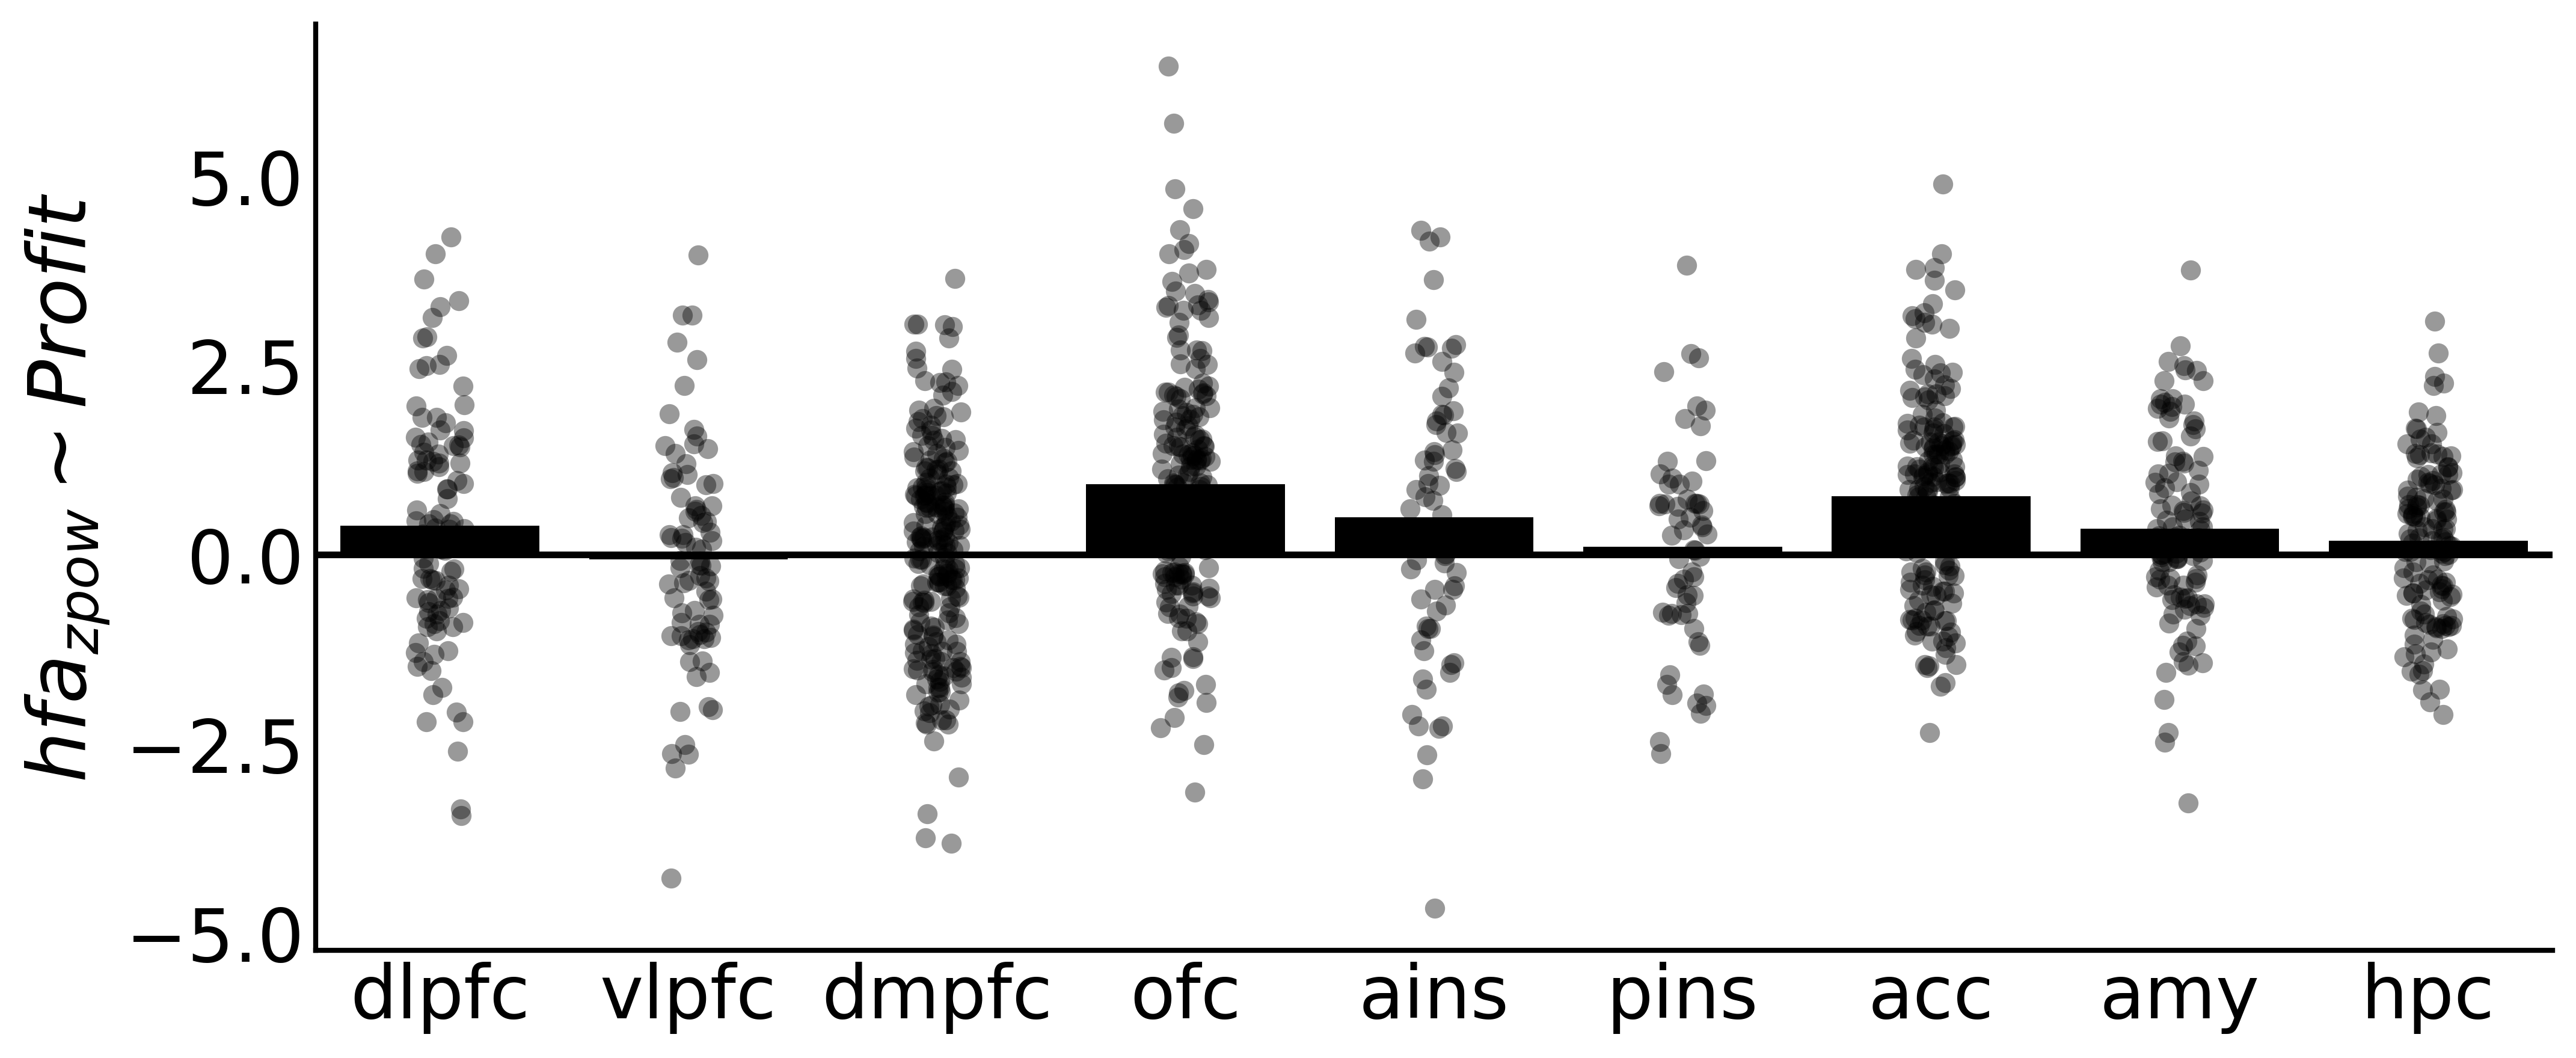

In [46]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim Profit$'


plot_roi_model_results(results,'roi',Profit_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

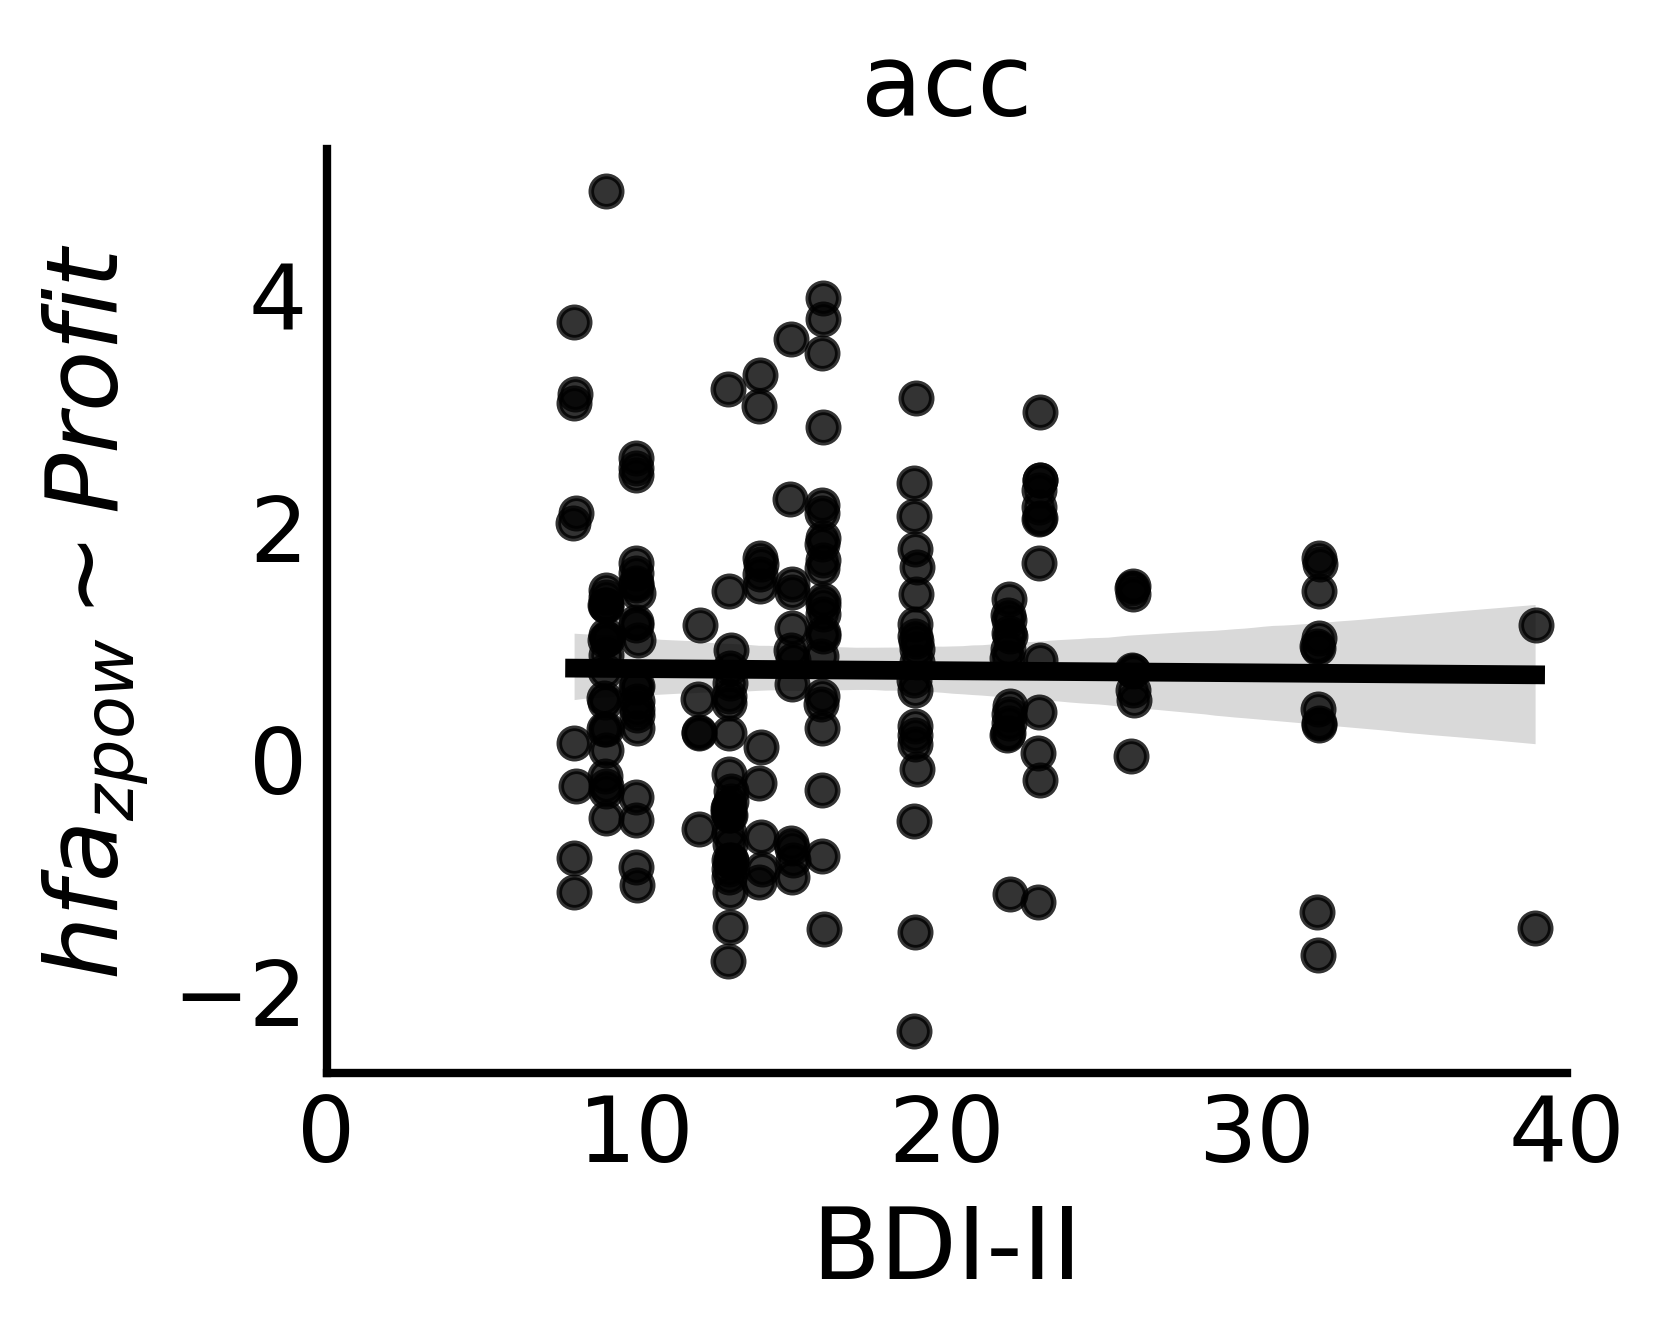

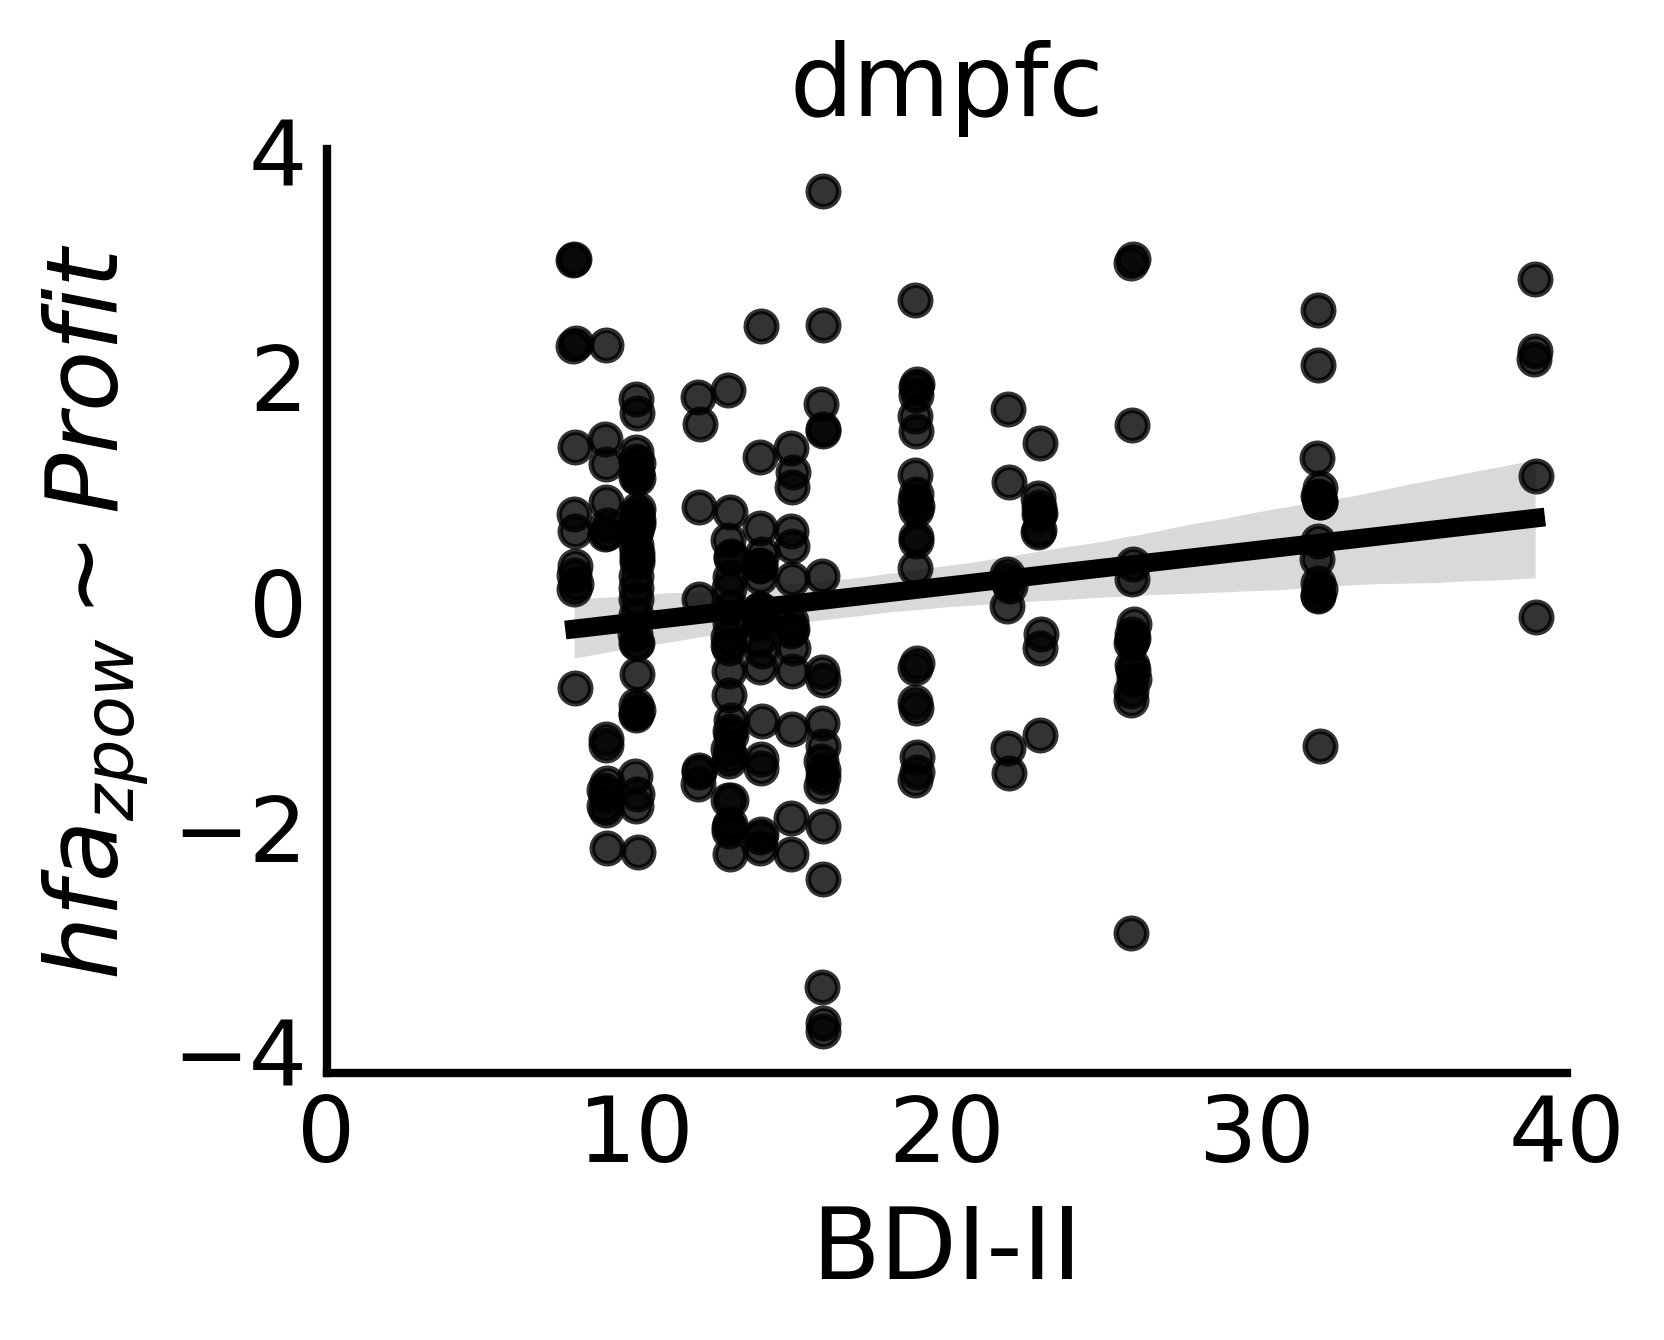

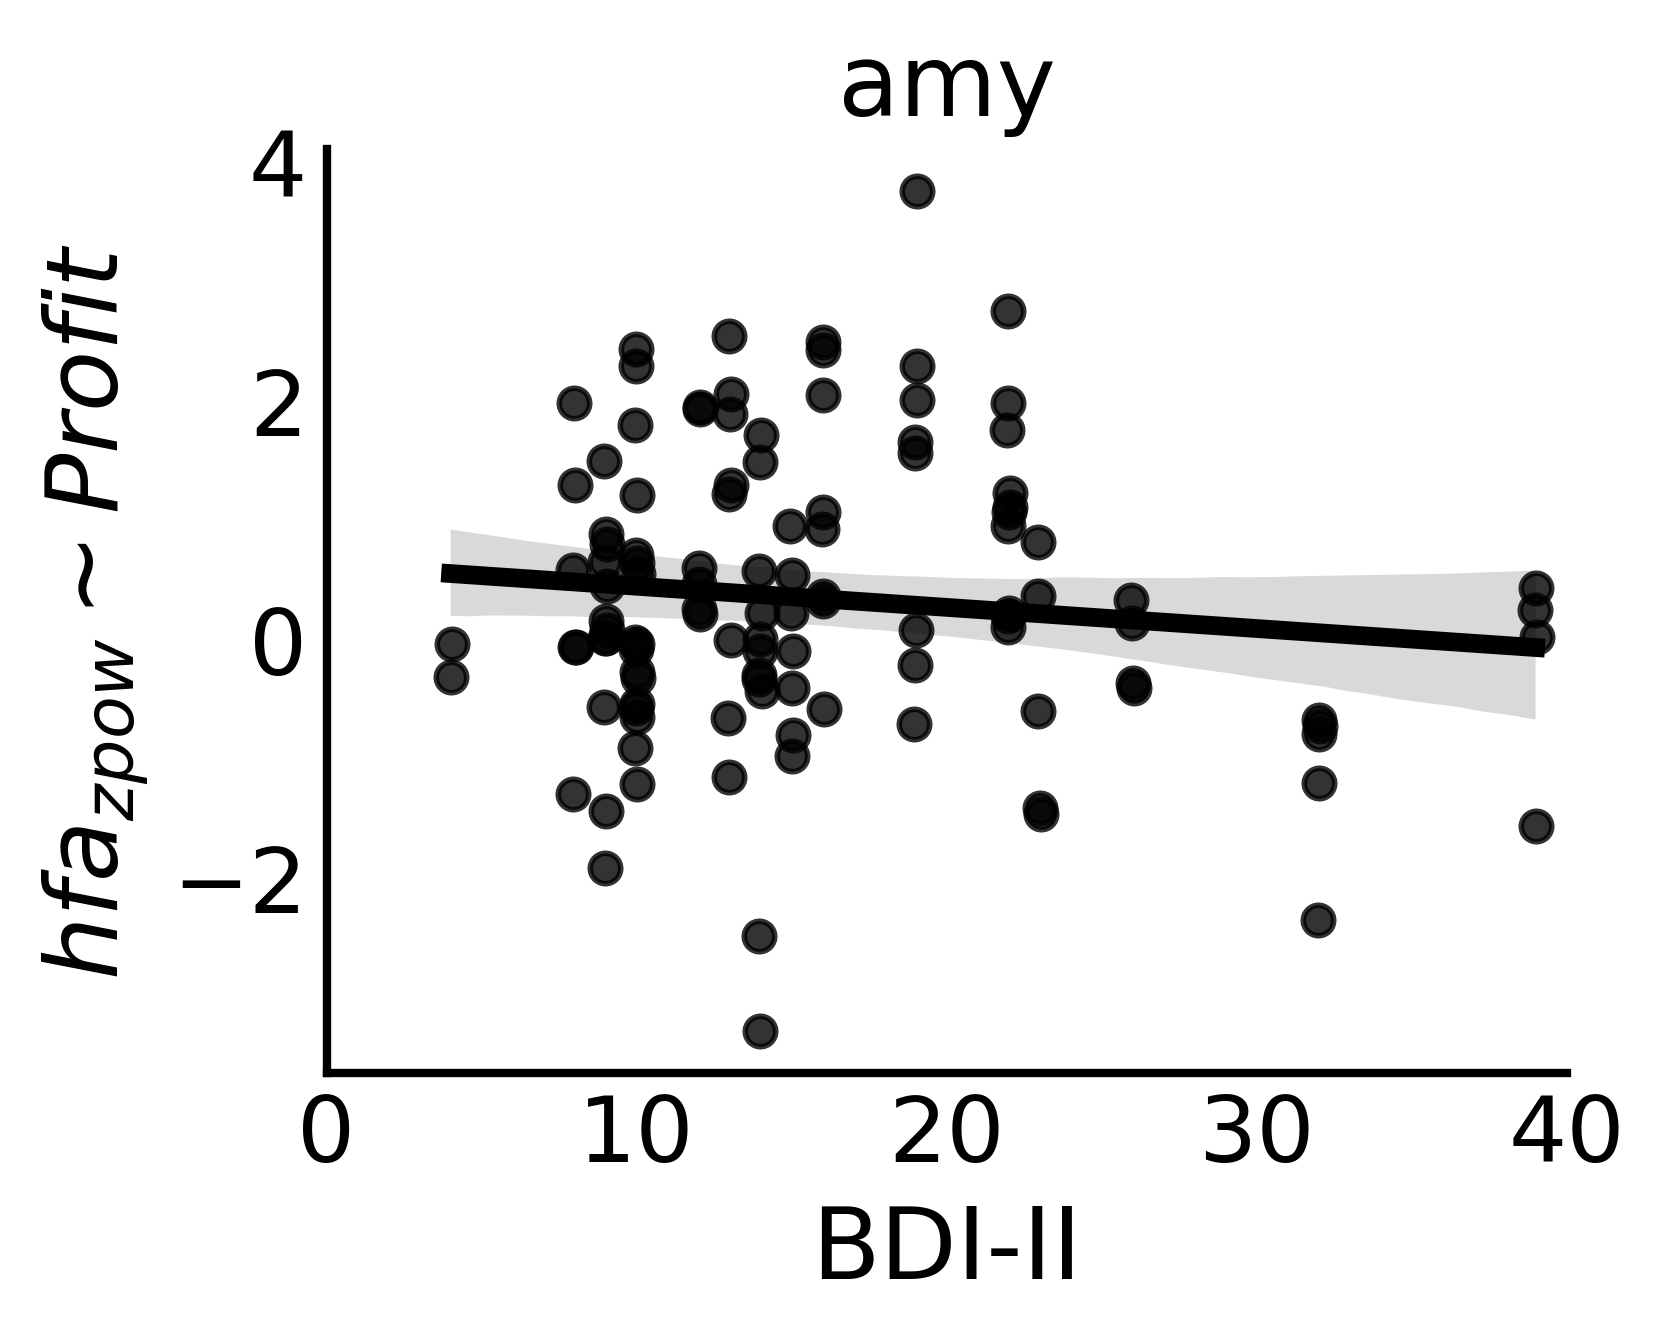

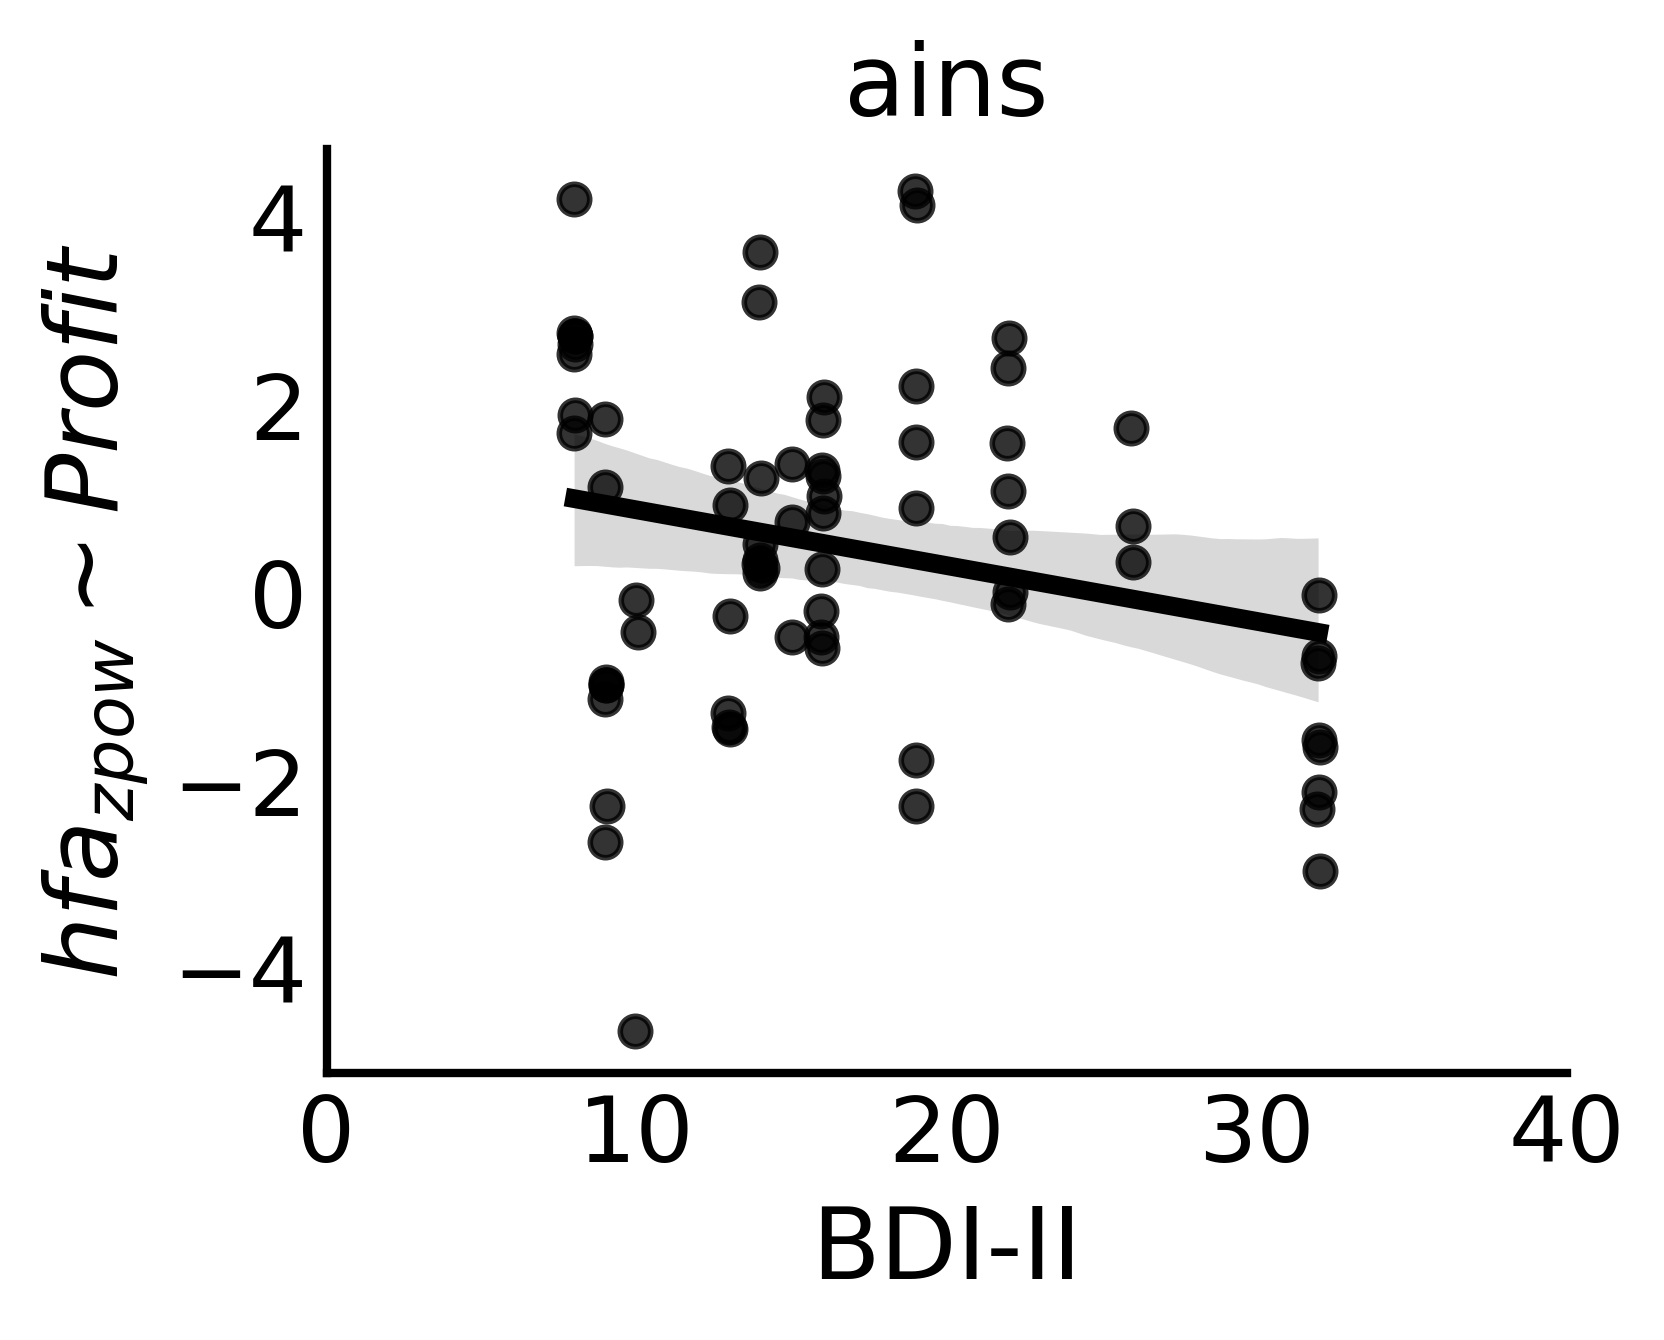

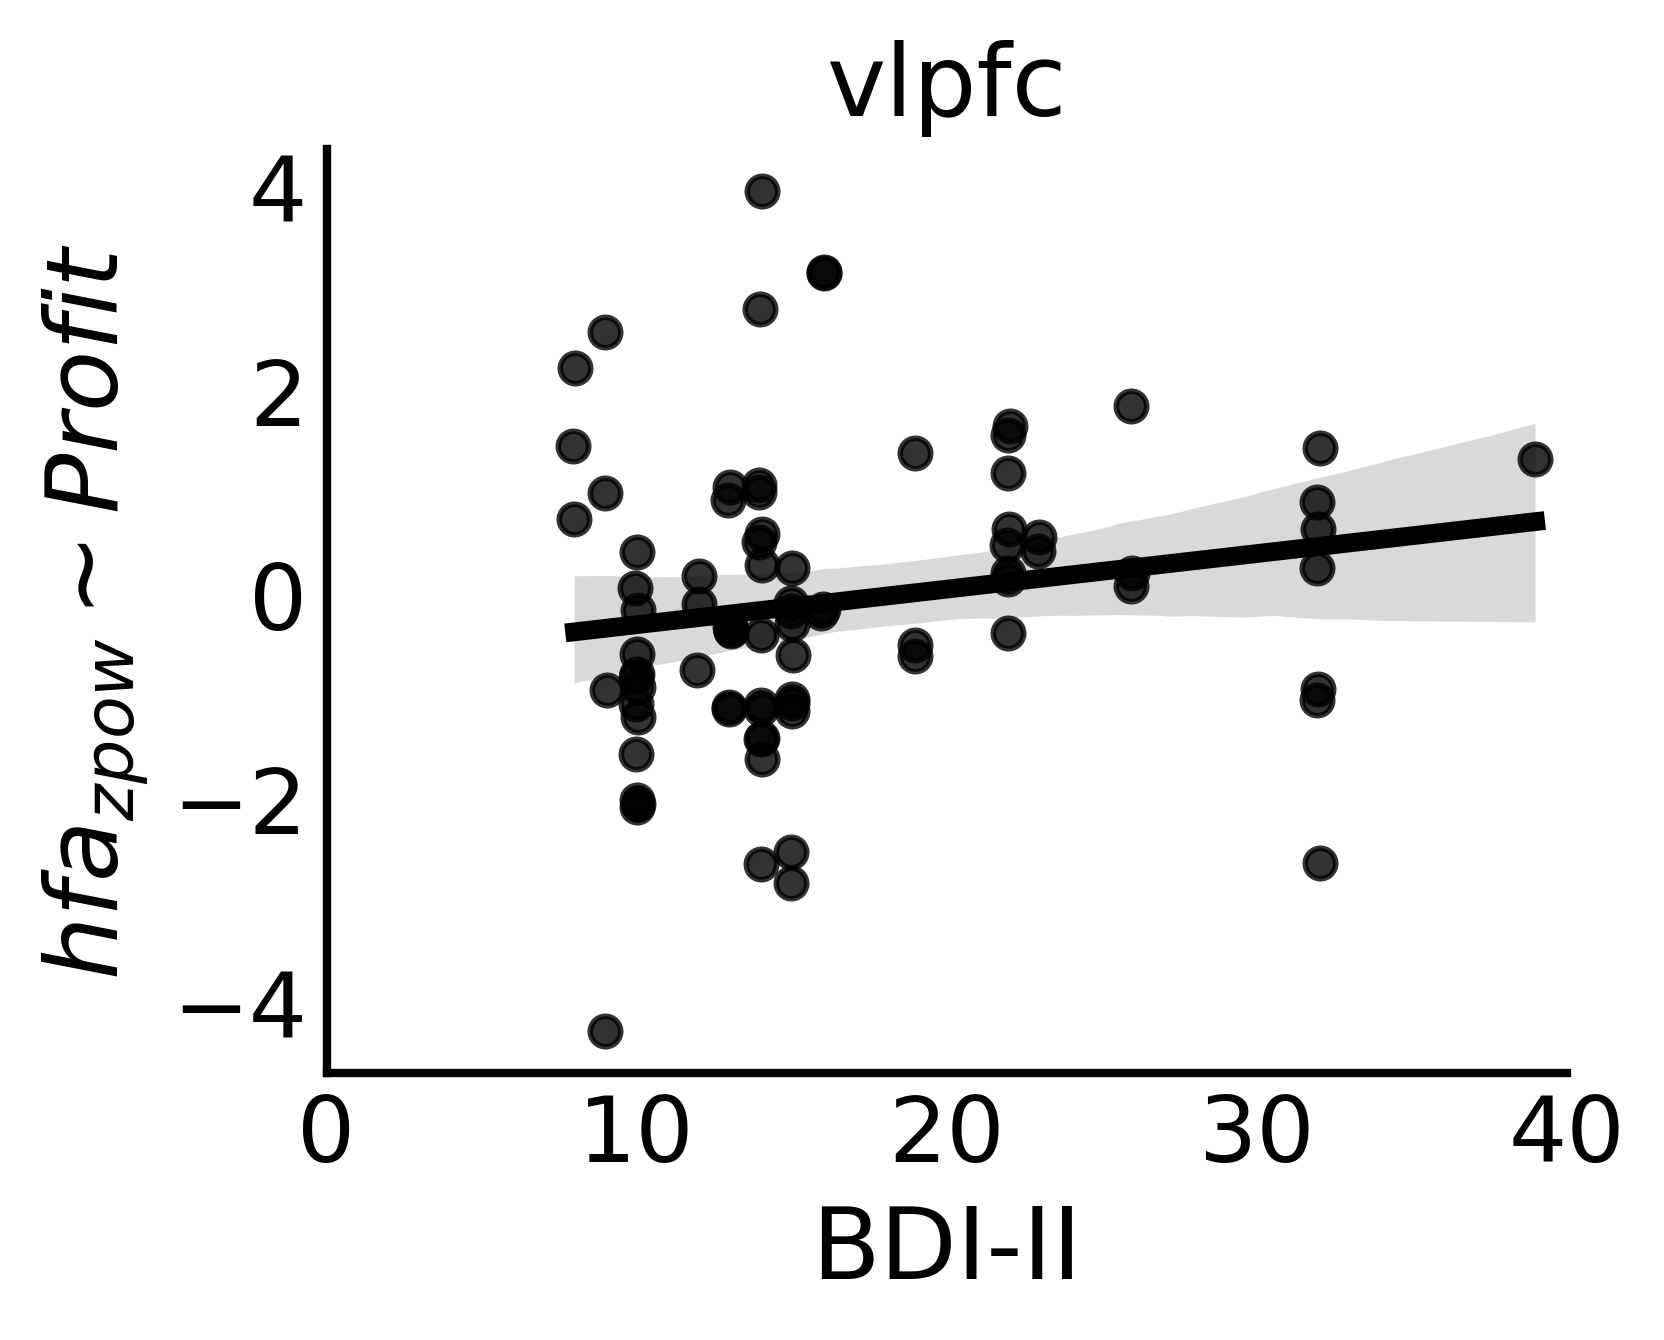

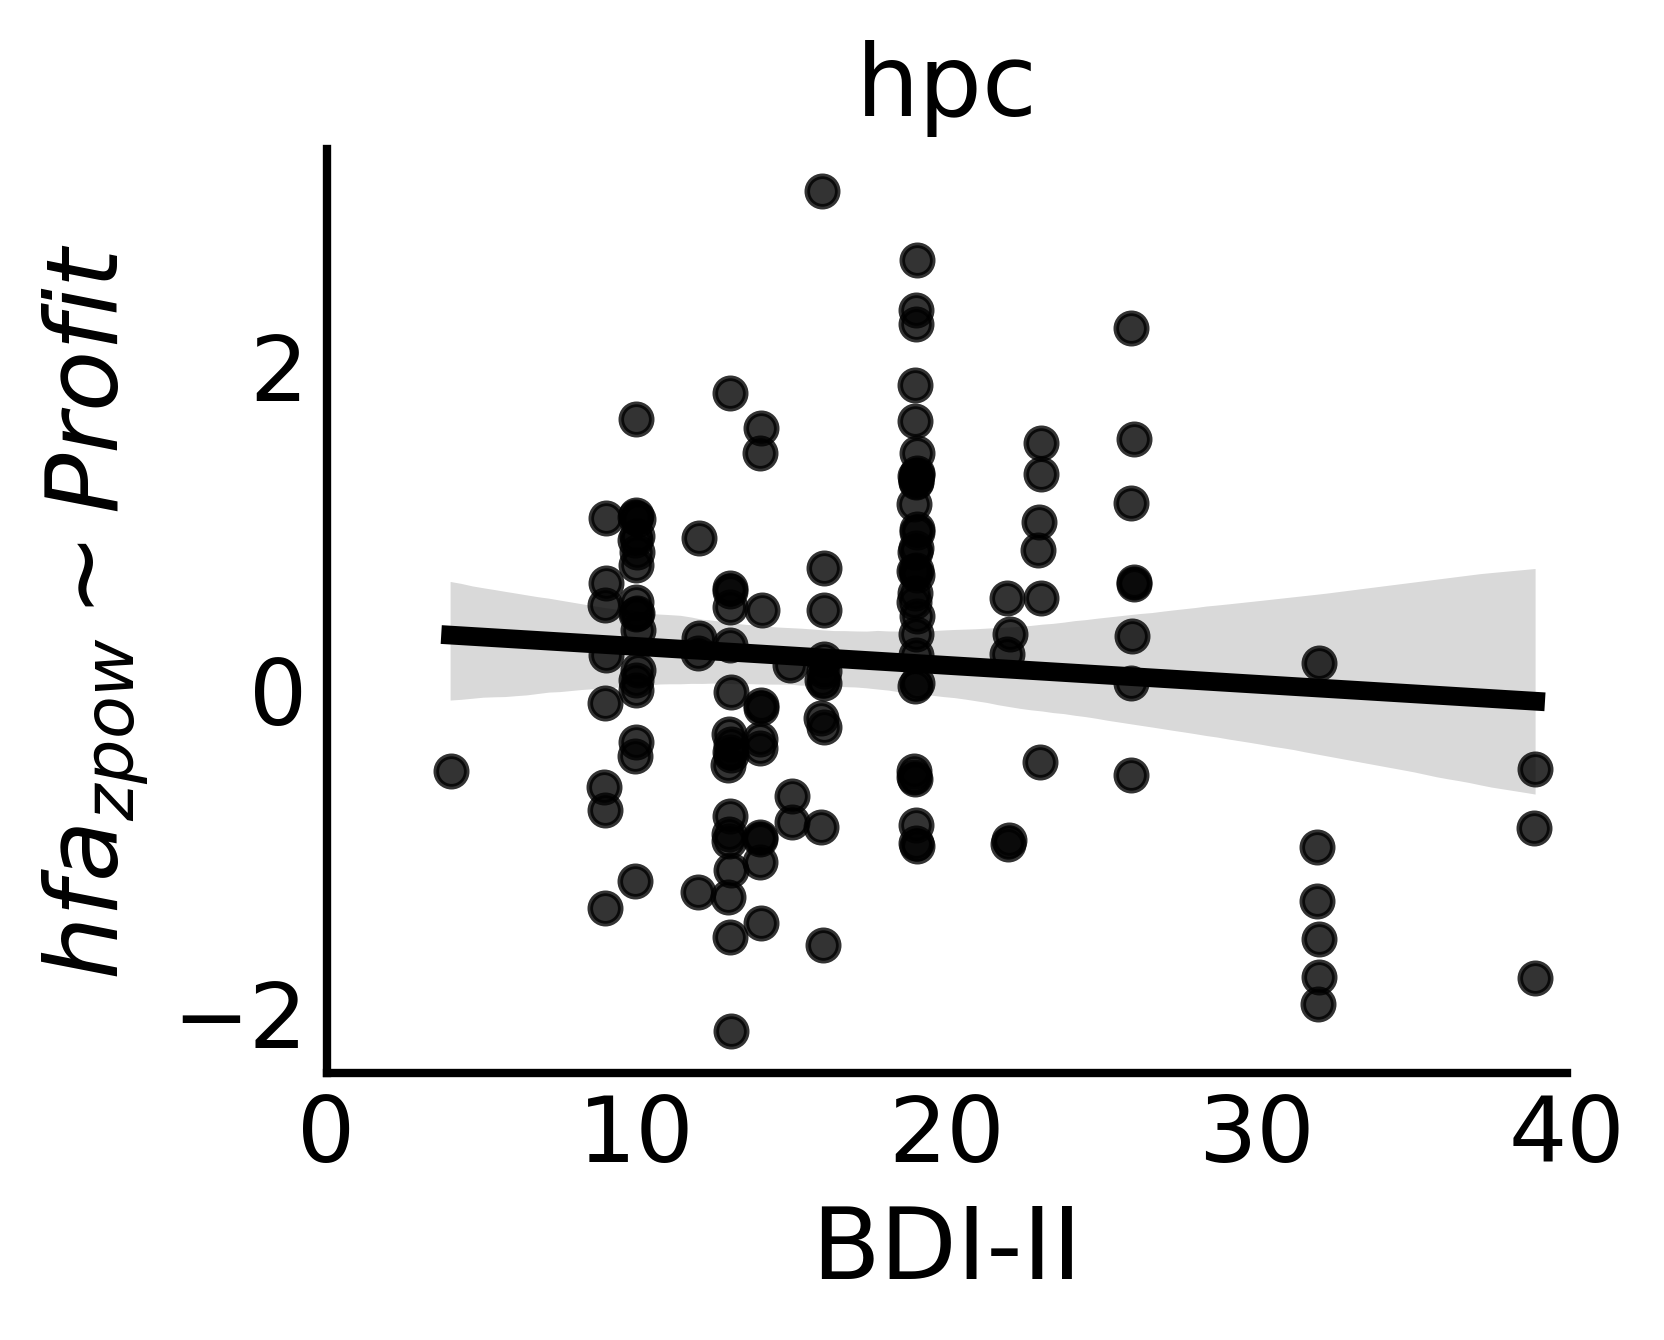

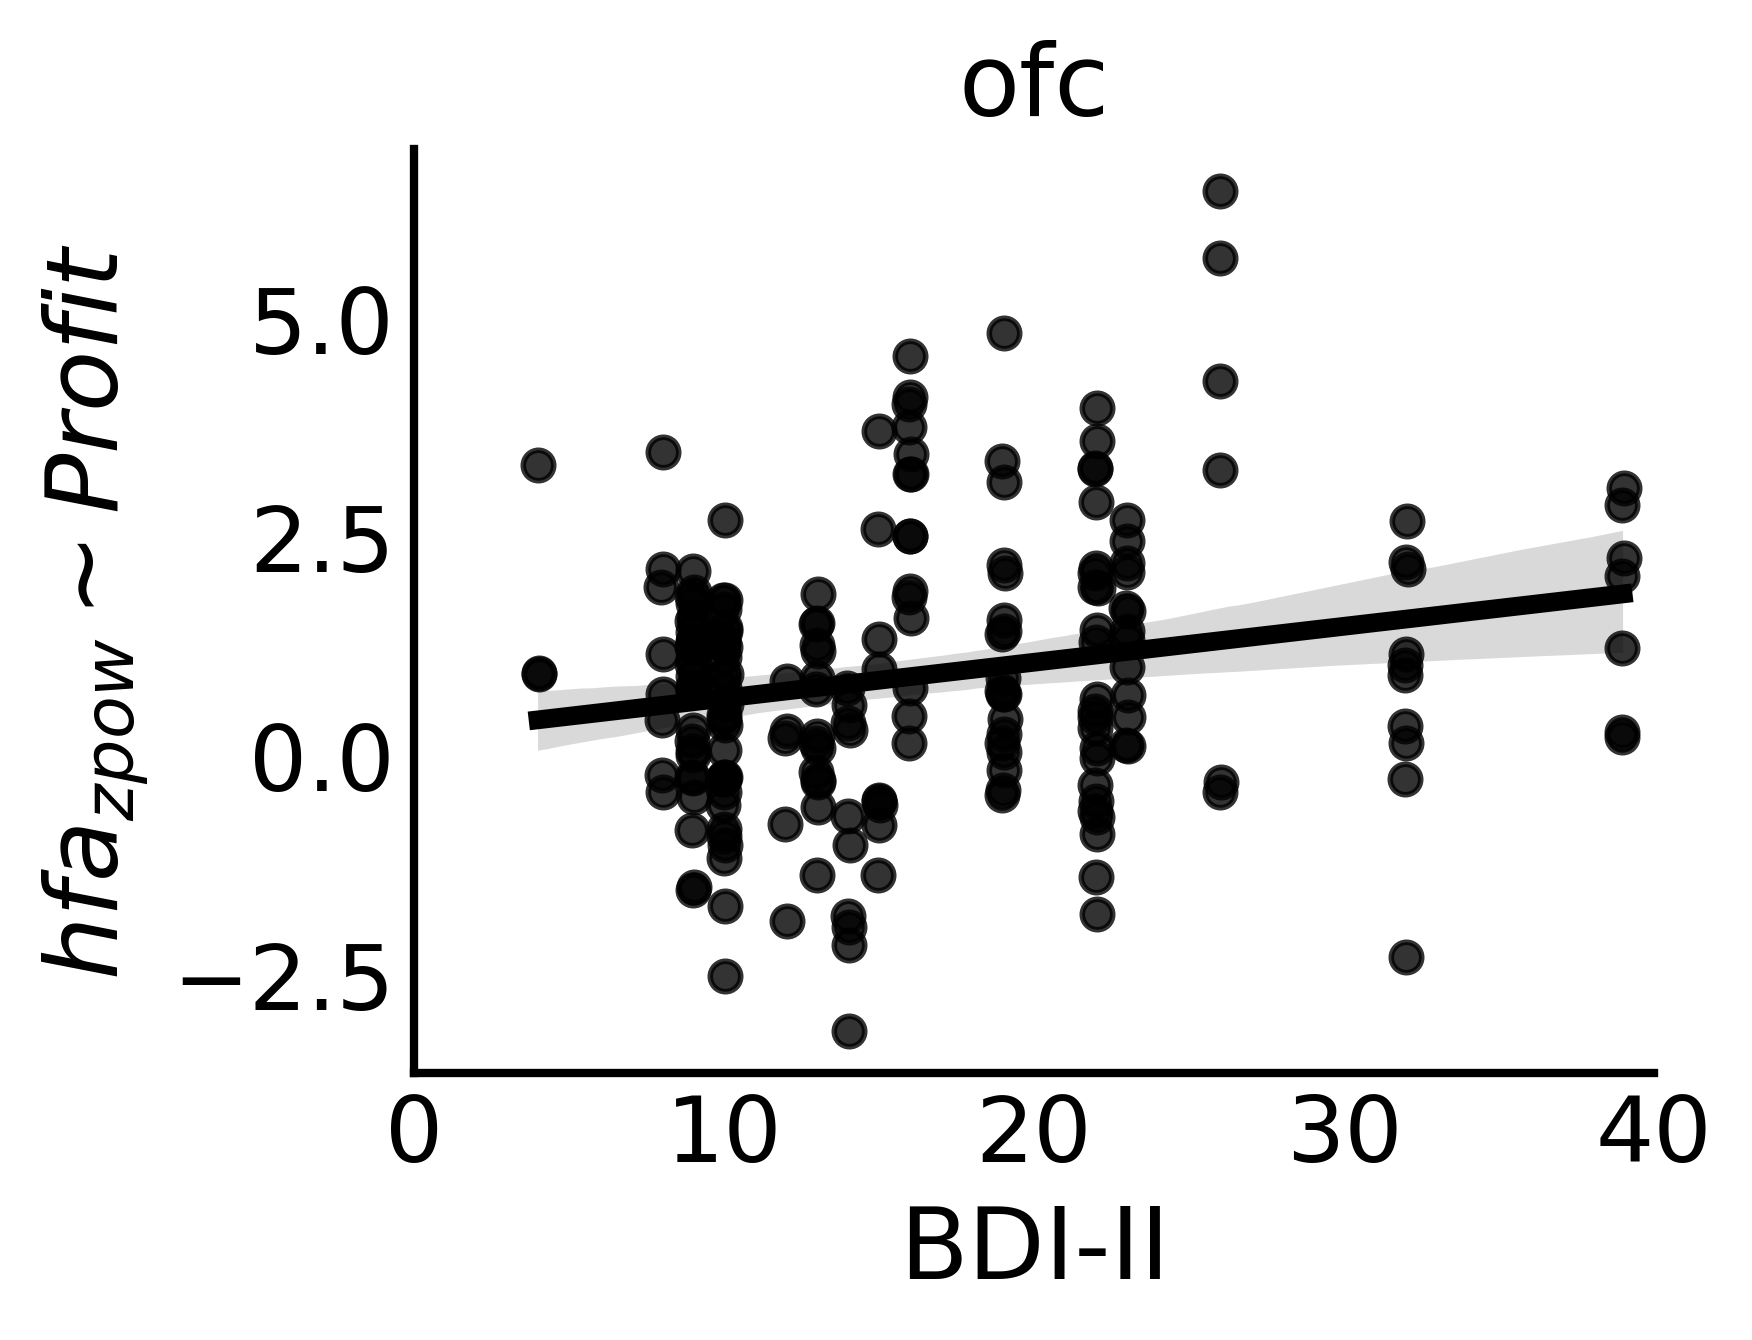

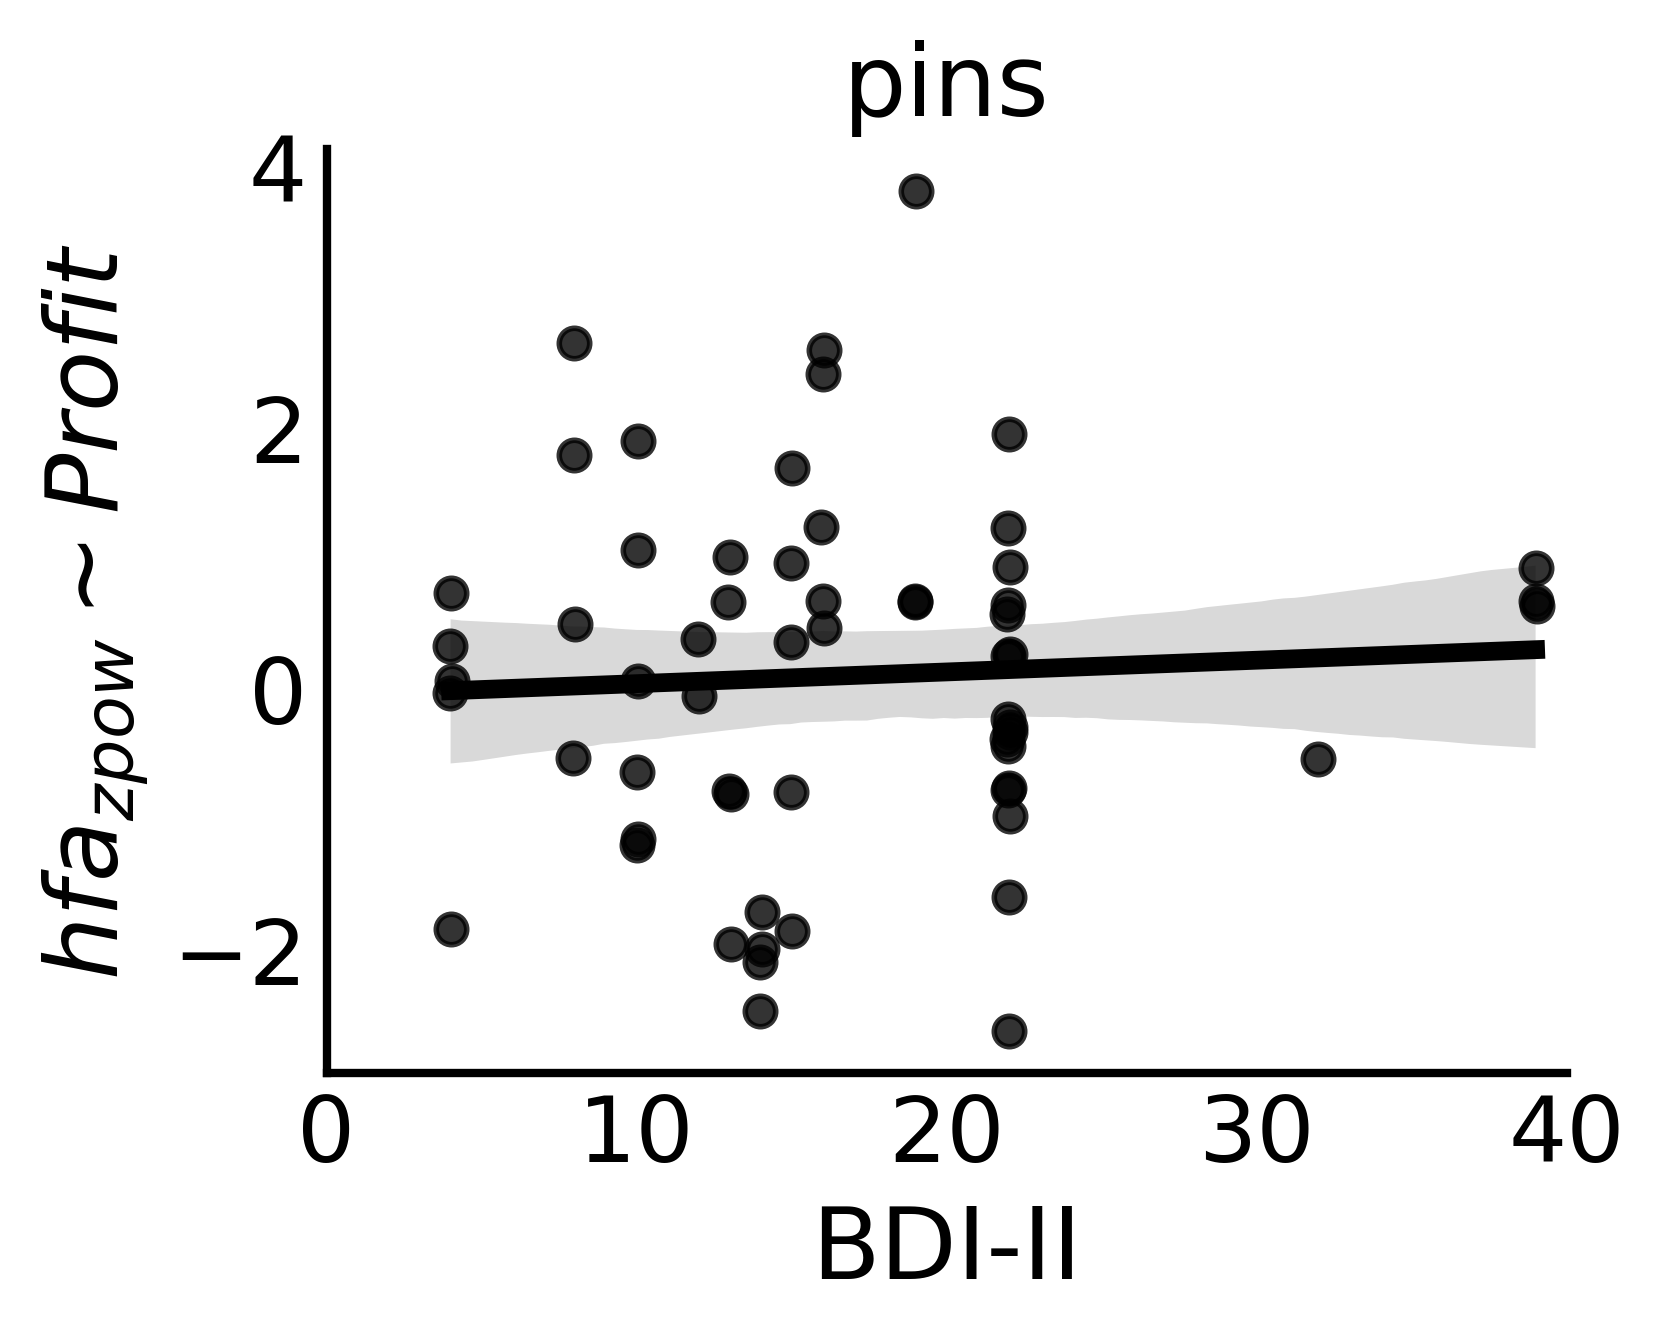

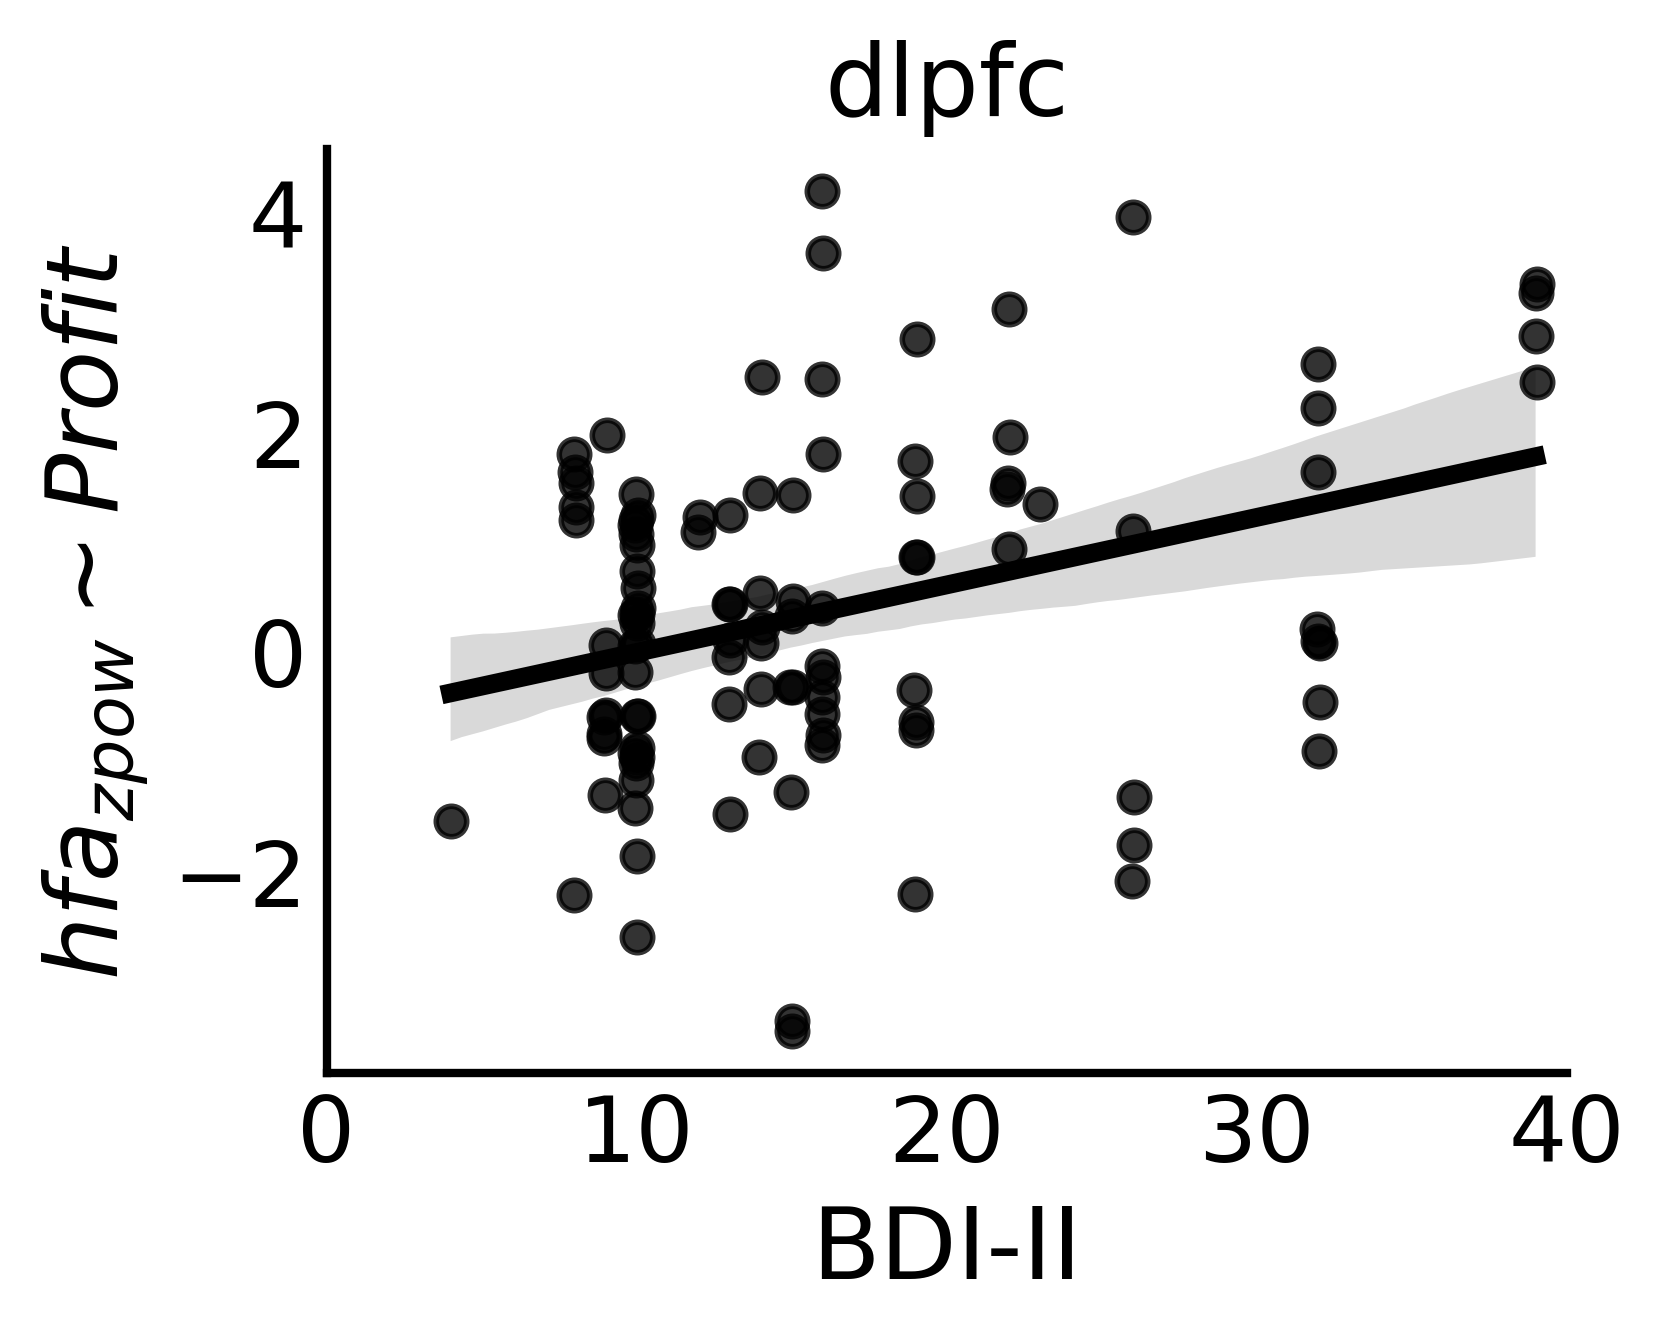

In [47]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_Profitmodel_Profit-coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_Profit',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim Profit$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [48]:
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_Profit.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        21:02:26                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9025      0.528     30.126     